<h1>C4 Solution</h1>

<h3>Install and import</h3>

In [6]:
%%capture
import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm

In [7]:
import os
import boto3
import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics

<h3>Get the data and copy it to S3</h3>

In [8]:
%%capture
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [9]:
!aws s3 cp dogImages s3://project4-dogimage-classfier/ --recursive

upload: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg to s3://project4-dogimage-classfier/test/001.Affenpinscher/Affenpinscher_00023.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg to s3://project4-dogimage-classfier/test/001.Affenpinscher/Affenpinscher_00003.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg to s3://project4-dogimage-classfier/test/001.Affenpinscher/Affenpinscher_00047.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg to s3://project4-dogimage-classfier/test/001.Affenpinscher/Affenpinscher_00036.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00125.jpg to s3://project4-dogimage-classfier/test/002.Afghan_hound/Afghan_hound_00125.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg to s3://project4-dogimage-classfier/test/001.Affenpinscher/Affenpinscher_00058.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00139.jpg to s3://project4-dogimage-classfier/test/002.Afghan_h

upload: dogImages/test/009.American_water_spaniel/American_water_spaniel_00646.jpg to s3://project4-dogimage-classfier/test/009.American_water_spaniel/American_water_spaniel_00646.jpg
upload: dogImages/test/009.American_water_spaniel/American_water_spaniel_00631.jpg to s3://project4-dogimage-classfier/test/009.American_water_spaniel/American_water_spaniel_00631.jpg
upload: dogImages/test/008.American_staffordshire_terrier/American_staffordshire_terrier_00579.jpg to s3://project4-dogimage-classfier/test/008.American_staffordshire_terrier/American_staffordshire_terrier_00579.jpg
upload: dogImages/test/010.Anatolian_shepherd_dog/Anatolian_shepherd_dog_00669.jpg to s3://project4-dogimage-classfier/test/010.Anatolian_shepherd_dog/Anatolian_shepherd_dog_00669.jpg
upload: dogImages/test/009.American_water_spaniel/American_water_spaniel_00655.jpg to s3://project4-dogimage-classfier/test/009.American_water_spaniel/American_water_spaniel_00655.jpg
upload: dogImages/test/009.American_water_spanie

upload: dogImages/test/015.Basset_hound/Basset_hound_01080.jpg to s3://project4-dogimage-classfier/test/015.Basset_hound/Basset_hound_01080.jpg
upload: dogImages/test/014.Basenji/Basenji_00978.jpg to s3://project4-dogimage-classfier/test/014.Basenji/Basenji_00978.jpg
upload: dogImages/test/014.Basenji/Basenji_01029.jpg to s3://project4-dogimage-classfier/test/014.Basenji/Basenji_01029.jpg
upload: dogImages/test/015.Basset_hound/Basset_hound_01106.jpg to s3://project4-dogimage-classfier/test/015.Basset_hound/Basset_hound_01106.jpg
upload: dogImages/test/016.Beagle/Beagle_01130.jpg to s3://project4-dogimage-classfier/test/016.Beagle/Beagle_01130.jpg
upload: dogImages/test/016.Beagle/Beagle_01144.jpg to s3://project4-dogimage-classfier/test/016.Beagle/Beagle_01144.jpg
upload: dogImages/test/016.Beagle/Beagle_01155.jpg to s3://project4-dogimage-classfier/test/016.Beagle/Beagle_01155.jpg
upload: dogImages/test/016.Beagle/Beagle_01141.jpg to s3://project4-dogimage-classfier/test/016.Beagle/B

upload: dogImages/test/024.Bichon_frise/Bichon_frise_01707.jpg to s3://project4-dogimage-classfier/test/024.Bichon_frise/Bichon_frise_01707.jpg
upload: dogImages/test/024.Bichon_frise/Bichon_frise_01757.jpg to s3://project4-dogimage-classfier/test/024.Bichon_frise/Bichon_frise_01757.jpg
upload: dogImages/test/024.Bichon_frise/Bichon_frise_01719.jpg to s3://project4-dogimage-classfier/test/024.Bichon_frise/Bichon_frise_01719.jpg
upload: dogImages/test/024.Bichon_frise/Bichon_frise_01753.jpg to s3://project4-dogimage-classfier/test/024.Bichon_frise/Bichon_frise_01753.jpg
upload: dogImages/test/023.Bernese_mountain_dog/Bernese_mountain_dog_01682.jpg to s3://project4-dogimage-classfier/test/023.Bernese_mountain_dog/Bernese_mountain_dog_01682.jpg
upload: dogImages/test/024.Bichon_frise/Bichon_frise_01759.jpg to s3://project4-dogimage-classfier/test/024.Bichon_frise/Bichon_frise_01759.jpg
upload: dogImages/test/022.Belgian_tervuren/Belgian_tervuren_01607.jpg to s3://project4-dogimage-classfi

upload: dogImages/test/032.Boston_terrier/Boston_terrier_02294.jpg to s3://project4-dogimage-classfier/test/032.Boston_terrier/Boston_terrier_02294.jpg
upload: dogImages/test/033.Bouvier_des_flandres/Bouvier_des_flandres_02304.jpg to s3://project4-dogimage-classfier/test/033.Bouvier_des_flandres/Bouvier_des_flandres_02304.jpg
upload: dogImages/test/033.Bouvier_des_flandres/Bouvier_des_flandres_02328.jpg to s3://project4-dogimage-classfier/test/033.Bouvier_des_flandres/Bouvier_des_flandres_02328.jpg
upload: dogImages/test/032.Boston_terrier/Boston_terrier_02291.jpg to s3://project4-dogimage-classfier/test/032.Boston_terrier/Boston_terrier_02291.jpg
upload: dogImages/test/032.Boston_terrier/Boston_terrier_02297.jpg to s3://project4-dogimage-classfier/test/032.Boston_terrier/Boston_terrier_02297.jpg
upload: dogImages/test/032.Boston_terrier/Boston_terrier_02287.jpg to s3://project4-dogimage-classfier/test/032.Boston_terrier/Boston_terrier_02287.jpg
upload: dogImages/test/033.Bouvier_des_f

upload: dogImages/test/040.Bulldog/Bulldog_02834.jpg to s3://project4-dogimage-classfier/test/040.Bulldog/Bulldog_02834.jpg
upload: dogImages/test/041.Bullmastiff/Bullmastiff_02904.jpg to s3://project4-dogimage-classfier/test/041.Bullmastiff/Bullmastiff_02904.jpg
upload: dogImages/test/041.Bullmastiff/Bullmastiff_02946.jpg to s3://project4-dogimage-classfier/test/041.Bullmastiff/Bullmastiff_02946.jpg
upload: dogImages/test/041.Bullmastiff/Bullmastiff_02876.jpg to s3://project4-dogimage-classfier/test/041.Bullmastiff/Bullmastiff_02876.jpg
upload: dogImages/test/041.Bullmastiff/Bullmastiff_02881.jpg to s3://project4-dogimage-classfier/test/041.Bullmastiff/Bullmastiff_02881.jpg
upload: dogImages/test/041.Bullmastiff/Bullmastiff_02929.jpg to s3://project4-dogimage-classfier/test/041.Bullmastiff/Bullmastiff_02929.jpg
upload: dogImages/test/042.Cairn_terrier/Cairn_terrier_02965.jpg to s3://project4-dogimage-classfier/test/042.Cairn_terrier/Cairn_terrier_02965.jpg
upload: dogImages/test/041.B

upload: dogImages/test/048.Chihuahua/Chihuahua_03411.jpg to s3://project4-dogimage-classfier/test/048.Chihuahua/Chihuahua_03411.jpg
upload: dogImages/test/047.Chesapeake_bay_retriever/Chesapeake_bay_retriever_03395.jpg to s3://project4-dogimage-classfier/test/047.Chesapeake_bay_retriever/Chesapeake_bay_retriever_03395.jpg
upload: dogImages/test/048.Chihuahua/Chihuahua_03403.jpg to s3://project4-dogimage-classfier/test/048.Chihuahua/Chihuahua_03403.jpg
upload: dogImages/test/048.Chihuahua/Chihuahua_03448.jpg to s3://project4-dogimage-classfier/test/048.Chihuahua/Chihuahua_03448.jpg
upload: dogImages/test/048.Chihuahua/Chihuahua_03427.jpg to s3://project4-dogimage-classfier/test/048.Chihuahua/Chihuahua_03427.jpg
upload: dogImages/test/048.Chihuahua/Chihuahua_03460.jpg to s3://project4-dogimage-classfier/test/048.Chihuahua/Chihuahua_03460.jpg
upload: dogImages/test/046.Cavalier_king_charles_spaniel/Cavalier_king_charles_spaniel_03326.jpg to s3://project4-dogimage-classfier/test/046.Cavali

upload: dogImages/test/057.Dalmatian/Dalmatian_04056.jpg to s3://project4-dogimage-classfier/test/057.Dalmatian/Dalmatian_04056.jpg
upload: dogImages/test/057.Dalmatian/Dalmatian_04059.jpg to s3://project4-dogimage-classfier/test/057.Dalmatian/Dalmatian_04059.jpg
upload: dogImages/test/057.Dalmatian/Dalmatian_04015.jpg to s3://project4-dogimage-classfier/test/057.Dalmatian/Dalmatian_04015.jpg
upload: dogImages/test/057.Dalmatian/Dalmatian_04047.jpg to s3://project4-dogimage-classfier/test/057.Dalmatian/Dalmatian_04047.jpg
upload: dogImages/test/057.Dalmatian/Dalmatian_04076.jpg to s3://project4-dogimage-classfier/test/057.Dalmatian/Dalmatian_04076.jpg
upload: dogImages/test/056.Dachshund/Dachshund_03991.jpg to s3://project4-dogimage-classfier/test/056.Dachshund/Dachshund_03991.jpg
upload: dogImages/test/056.Dachshund/Dachshund_03966.jpg to s3://project4-dogimage-classfier/test/056.Dachshund/Dachshund_03966.jpg
upload: dogImages/test/057.Dalmatian/Dalmatian_04021.jpg to s3://project4-do

upload: dogImages/test/064.English_toy_spaniel/English_toy_spaniel_04542.jpg to s3://project4-dogimage-classfier/test/064.English_toy_spaniel/English_toy_spaniel_04542.jpg
upload: dogImages/test/063.English_springer_spaniel/English_springer_spaniel_04484.jpg to s3://project4-dogimage-classfier/test/063.English_springer_spaniel/English_springer_spaniel_04484.jpg
upload: dogImages/test/065.Entlebucher_mountain_dog/Entlebucher_mountain_dog_04595.jpg to s3://project4-dogimage-classfier/test/065.Entlebucher_mountain_dog/Entlebucher_mountain_dog_04595.jpg
upload: dogImages/test/065.Entlebucher_mountain_dog/Entlebucher_mountain_dog_04580.jpg to s3://project4-dogimage-classfier/test/065.Entlebucher_mountain_dog/Entlebucher_mountain_dog_04580.jpg
upload: dogImages/test/066.Field_spaniel/Field_spaniel_04619.jpg to s3://project4-dogimage-classfier/test/066.Field_spaniel/Field_spaniel_04619.jpg
upload: dogImages/test/066.Field_spaniel/Field_spaniel_04608.jpg to s3://project4-dogimage-classfier/tes

upload: dogImages/test/074.Giant_schnauzer/Giant_schnauzer_05104.jpg to s3://project4-dogimage-classfier/test/074.Giant_schnauzer/Giant_schnauzer_05104.jpg
upload: dogImages/test/073.German_wirehaired_pointer/German_wirehaired_pointer_05064.jpg to s3://project4-dogimage-classfier/test/073.German_wirehaired_pointer/German_wirehaired_pointer_05064.jpg
upload: dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg to s3://project4-dogimage-classfier/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
upload: dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04986.jpg to s3://project4-dogimage-classfier/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04986.jpg
upload: dogImages/test/074.Giant_schnauzer/Giant_schnauzer_05120.jpg to s3://project4-dogimage-classfier/test/074.Giant_schnauzer/Giant_schnauzer_05120.jpg
upload: dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04980.jpg t

upload: dogImages/test/082.Havanese/Havanese_05571.jpg to s3://project4-dogimage-classfier/test/082.Havanese/Havanese_05571.jpg
upload: dogImages/test/081.Greyhound/Greyhound_05552.jpg to s3://project4-dogimage-classfier/test/081.Greyhound/Greyhound_05552.jpg
upload: dogImages/test/082.Havanese/Havanese_05585.jpg to s3://project4-dogimage-classfier/test/082.Havanese/Havanese_05585.jpg
upload: dogImages/test/082.Havanese/Havanese_05614.jpg to s3://project4-dogimage-classfier/test/082.Havanese/Havanese_05614.jpg
upload: dogImages/test/082.Havanese/Havanese_05574.jpg to s3://project4-dogimage-classfier/test/082.Havanese/Havanese_05574.jpg
upload: dogImages/test/081.Greyhound/Greyhound_05565.jpg to s3://project4-dogimage-classfier/test/081.Greyhound/Greyhound_05565.jpg
upload: dogImages/test/082.Havanese/Havanese_05625.jpg to s3://project4-dogimage-classfier/test/082.Havanese/Havanese_05625.jpg
upload: dogImages/test/082.Havanese/Havanese_05566.jpg to s3://project4-dogimage-classfier/test/

upload: dogImages/test/089.Irish_wolfhound/Irish_wolfhound_06063.jpg to s3://project4-dogimage-classfier/test/089.Irish_wolfhound/Irish_wolfhound_06063.jpg
upload: dogImages/test/090.Italian_greyhound/Italian_greyhound_06153.jpg to s3://project4-dogimage-classfier/test/090.Italian_greyhound/Italian_greyhound_06153.jpg
upload: dogImages/test/091.Japanese_chin/Japanese_chin_06166.jpg to s3://project4-dogimage-classfier/test/091.Japanese_chin/Japanese_chin_06166.jpg
upload: dogImages/test/090.Italian_greyhound/Italian_greyhound_06146.jpg to s3://project4-dogimage-classfier/test/090.Italian_greyhound/Italian_greyhound_06146.jpg
upload: dogImages/test/090.Italian_greyhound/Italian_greyhound_06149.jpg to s3://project4-dogimage-classfier/test/090.Italian_greyhound/Italian_greyhound_06149.jpg
upload: dogImages/test/090.Italian_greyhound/Italian_greyhound_06114.jpg to s3://project4-dogimage-classfier/test/090.Italian_greyhound/Italian_greyhound_06114.jpg
upload: dogImages/test/090.Italian_greyh

upload: dogImages/test/101.Maltese/Maltese_06757.jpg to s3://project4-dogimage-classfier/test/101.Maltese/Maltese_06757.jpg
upload: dogImages/test/101.Maltese/Maltese_06716.jpg to s3://project4-dogimage-classfier/test/101.Maltese/Maltese_06716.jpg
upload: dogImages/test/100.Lowchen/Lowchen_06694.jpg to s3://project4-dogimage-classfier/test/100.Lowchen/Lowchen_06694.jpg
upload: dogImages/test/100.Lowchen/Lowchen_06699.jpg to s3://project4-dogimage-classfier/test/100.Lowchen/Lowchen_06699.jpg
upload: dogImages/test/101.Maltese/Maltese_06766.jpg to s3://project4-dogimage-classfier/test/101.Maltese/Maltese_06766.jpg
upload: dogImages/test/101.Maltese/Maltese_06754.jpg to s3://project4-dogimage-classfier/test/101.Maltese/Maltese_06754.jpg
upload: dogImages/test/102.Manchester_terrier/Manchester_terrier_06799.jpg to s3://project4-dogimage-classfier/test/102.Manchester_terrier/Manchester_terrier_06799.jpg
upload: dogImages/test/102.Manchester_terrier/Manchester_terrier_06805.jpg to s3://proje

upload: dogImages/test/111.Norwich_terrier/Norwich_terrier_07240.jpg to s3://project4-dogimage-classfier/test/111.Norwich_terrier/Norwich_terrier_07240.jpg
upload: dogImages/test/111.Norwich_terrier/Norwich_terrier_07253.jpg to s3://project4-dogimage-classfier/test/111.Norwich_terrier/Norwich_terrier_07253.jpg
upload: dogImages/test/111.Norwich_terrier/Norwich_terrier_07229.jpg to s3://project4-dogimage-classfier/test/111.Norwich_terrier/Norwich_terrier_07229.jpg
upload: dogImages/test/112.Nova_scotia_duck_tolling_retriever/Nova_scotia_duck_tolling_retriever_07331.jpg to s3://project4-dogimage-classfier/test/112.Nova_scotia_duck_tolling_retriever/Nova_scotia_duck_tolling_retriever_07331.jpg
upload: dogImages/test/113.Old_english_sheepdog/Old_english_sheepdog_07390.jpg to s3://project4-dogimage-classfier/test/113.Old_english_sheepdog/Old_english_sheepdog_07390.jpg
upload: dogImages/test/112.Nova_scotia_duck_tolling_retriever/Nova_scotia_duck_tolling_retriever_07291.jpg to s3://project4-

upload: dogImages/test/121.Plott/Plott_07795.jpg to s3://project4-dogimage-classfier/test/121.Plott/Plott_07795.jpg
upload: dogImages/test/120.Pharaoh_hound/Pharaoh_hound_07750.jpg to s3://project4-dogimage-classfier/test/120.Pharaoh_hound/Pharaoh_hound_07750.jpg
upload: dogImages/test/123.Pomeranian/Pomeranian_07873.jpg to s3://project4-dogimage-classfier/test/123.Pomeranian/Pomeranian_07873.jpg
upload: dogImages/test/124.Poodle/Poodle_07904.jpg to s3://project4-dogimage-classfier/test/124.Poodle/Poodle_07904.jpg
upload: dogImages/test/124.Poodle/Poodle_07910.jpg to s3://project4-dogimage-classfier/test/124.Poodle/Poodle_07910.jpg
upload: dogImages/test/124.Poodle/Poodle_07903.jpg to s3://project4-dogimage-classfier/test/124.Poodle/Poodle_07903.jpg
upload: dogImages/test/125.Portuguese_water_dog/Portuguese_water_dog_07963.jpg to s3://project4-dogimage-classfier/test/125.Portuguese_water_dog/Portuguese_water_dog_07963.jpg
upload: dogImages/test/123.Pomeranian/Pomeranian_07861.jpg to s3

upload: dogImages/train/001.Affenpinscher/Affenpinscher_00013.jpg to s3://project4-dogimage-classfier/train/001.Affenpinscher/Affenpinscher_00013.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00014.jpg to s3://project4-dogimage-classfier/train/001.Affenpinscher/Affenpinscher_00014.jpg
upload: dogImages/test/132.Xoloitzcuintli/Xoloitzcuintli_08312.jpg to s3://project4-dogimage-classfier/test/132.Xoloitzcuintli/Xoloitzcuintli_08312.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00012.jpg to s3://project4-dogimage-classfier/train/001.Affenpinscher/Affenpinscher_00012.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00021.jpg to s3://project4-dogimage-classfier/train/001.Affenpinscher/Affenpinscher_00021.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00016.jpg to s3://project4-dogimage-classfier/train/001.Affenpinscher/Affenpinscher_00016.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00011.jpg to s3://project4-dogimage-classf

upload: dogImages/train/002.Afghan_hound/Afghan_hound_00081.jpg to s3://project4-dogimage-classfier/train/002.Afghan_hound/Afghan_hound_00081.jpg
upload: dogImages/train/002.Afghan_hound/Afghan_hound_00087.jpg to s3://project4-dogimage-classfier/train/002.Afghan_hound/Afghan_hound_00087.jpg
upload: dogImages/train/002.Afghan_hound/Afghan_hound_00084.jpg to s3://project4-dogimage-classfier/train/002.Afghan_hound/Afghan_hound_00084.jpg
upload: dogImages/train/002.Afghan_hound/Afghan_hound_00086.jpg to s3://project4-dogimage-classfier/train/002.Afghan_hound/Afghan_hound_00086.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00070.jpg to s3://project4-dogimage-classfier/train/001.Affenpinscher/Affenpinscher_00070.jpg
upload: dogImages/train/002.Afghan_hound/Afghan_hound_00085.jpg to s3://project4-dogimage-classfier/train/002.Afghan_hound/Afghan_hound_00085.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00073.jpg to s3://project4-dogimage-classfier/train/001.Affenpin

upload: dogImages/train/003.Airedale_terrier/Airedale_terrier_00162.jpg to s3://project4-dogimage-classfier/train/003.Airedale_terrier/Airedale_terrier_00162.jpg
upload: dogImages/train/003.Airedale_terrier/Airedale_terrier_00157.jpg to s3://project4-dogimage-classfier/train/003.Airedale_terrier/Airedale_terrier_00157.jpg
upload: dogImages/train/003.Airedale_terrier/Airedale_terrier_00158.jpg to s3://project4-dogimage-classfier/train/003.Airedale_terrier/Airedale_terrier_00158.jpg
upload: dogImages/train/002.Afghan_hound/Afghan_hound_00137.jpg to s3://project4-dogimage-classfier/train/002.Afghan_hound/Afghan_hound_00137.jpg
upload: dogImages/train/002.Afghan_hound/Afghan_hound_00102.jpg to s3://project4-dogimage-classfier/train/002.Afghan_hound/Afghan_hound_00102.jpg
upload: dogImages/train/003.Airedale_terrier/Airedale_terrier_00163.jpg to s3://project4-dogimage-classfier/train/003.Airedale_terrier/Airedale_terrier_00163.jpg
upload: dogImages/train/003.Airedale_terrier/Airedale_terrie

upload: dogImages/train/003.Airedale_terrier/Airedale_terrier_00217.jpg to s3://project4-dogimage-classfier/train/003.Airedale_terrier/Airedale_terrier_00217.jpg
upload: dogImages/train/004.Akita/Akita_00228.jpg to s3://project4-dogimage-classfier/train/004.Akita/Akita_00228.jpg
upload: dogImages/train/004.Akita/Akita_00230.jpg to s3://project4-dogimage-classfier/train/004.Akita/Akita_00230.jpg
upload: dogImages/train/004.Akita/Akita_00225.jpg to s3://project4-dogimage-classfier/train/004.Akita/Akita_00225.jpg
upload: dogImages/train/004.Akita/Akita_00233.jpg to s3://project4-dogimage-classfier/train/004.Akita/Akita_00233.jpg
upload: dogImages/train/004.Akita/Akita_00236.jpg to s3://project4-dogimage-classfier/train/004.Akita/Akita_00236.jpg
upload: dogImages/train/004.Akita/Akita_00234.jpg to s3://project4-dogimage-classfier/train/004.Akita/Akita_00234.jpg
upload: dogImages/train/004.Akita/Akita_00231.jpg to s3://project4-dogimage-classfier/train/004.Akita/Akita_00231.jpg
upload: dogI

upload: dogImages/train/005.Alaskan_malamute/Alaskan_malamute_00315.jpg to s3://project4-dogimage-classfier/train/005.Alaskan_malamute/Alaskan_malamute_00315.jpg
upload: dogImages/train/005.Alaskan_malamute/Alaskan_malamute_00308.jpg to s3://project4-dogimage-classfier/train/005.Alaskan_malamute/Alaskan_malamute_00308.jpg
upload: dogImages/train/005.Alaskan_malamute/Alaskan_malamute_00320.jpg to s3://project4-dogimage-classfier/train/005.Alaskan_malamute/Alaskan_malamute_00320.jpg
upload: dogImages/train/005.Alaskan_malamute/Alaskan_malamute_00319.jpg to s3://project4-dogimage-classfier/train/005.Alaskan_malamute/Alaskan_malamute_00319.jpg
upload: dogImages/train/005.Alaskan_malamute/Alaskan_malamute_00321.jpg to s3://project4-dogimage-classfier/train/005.Alaskan_malamute/Alaskan_malamute_00321.jpg
upload: dogImages/train/005.Alaskan_malamute/Alaskan_malamute_00316.jpg to s3://project4-dogimage-classfier/train/005.Alaskan_malamute/Alaskan_malamute_00316.jpg
upload: dogImages/train/005.

upload: dogImages/train/005.Alaskan_malamute/Alaskan_malamute_00382.jpg to s3://project4-dogimage-classfier/train/005.Alaskan_malamute/Alaskan_malamute_00382.jpg
upload: dogImages/train/005.Alaskan_malamute/Alaskan_malamute_00384.jpg to s3://project4-dogimage-classfier/train/005.Alaskan_malamute/Alaskan_malamute_00384.jpg
upload: dogImages/train/005.Alaskan_malamute/Alaskan_malamute_00378.jpg to s3://project4-dogimage-classfier/train/005.Alaskan_malamute/Alaskan_malamute_00378.jpg
upload: dogImages/train/005.Alaskan_malamute/Alaskan_malamute_00385.jpg to s3://project4-dogimage-classfier/train/005.Alaskan_malamute/Alaskan_malamute_00385.jpg
upload: dogImages/train/005.Alaskan_malamute/Alaskan_malamute_00388.jpg to s3://project4-dogimage-classfier/train/005.Alaskan_malamute/Alaskan_malamute_00388.jpg
upload: dogImages/train/005.Alaskan_malamute/Alaskan_malamute_00391.jpg to s3://project4-dogimage-classfier/train/005.Alaskan_malamute/Alaskan_malamute_00391.jpg
upload: dogImages/train/005.

upload: dogImages/train/006.American_eskimo_dog/American_eskimo_dog_00450.jpg to s3://project4-dogimage-classfier/train/006.American_eskimo_dog/American_eskimo_dog_00450.jpg
upload: dogImages/train/006.American_eskimo_dog/American_eskimo_dog_00453.jpg to s3://project4-dogimage-classfier/train/006.American_eskimo_dog/American_eskimo_dog_00453.jpg
upload: dogImages/train/006.American_eskimo_dog/American_eskimo_dog_00441.jpg to s3://project4-dogimage-classfier/train/006.American_eskimo_dog/American_eskimo_dog_00441.jpg
upload: dogImages/train/006.American_eskimo_dog/American_eskimo_dog_00442.jpg to s3://project4-dogimage-classfier/train/006.American_eskimo_dog/American_eskimo_dog_00442.jpg
upload: dogImages/train/006.American_eskimo_dog/American_eskimo_dog_00444.jpg to s3://project4-dogimage-classfier/train/006.American_eskimo_dog/American_eskimo_dog_00444.jpg
upload: dogImages/train/006.American_eskimo_dog/American_eskimo_dog_00445.jpg to s3://project4-dogimage-classfier/train/006.Americ

upload: dogImages/train/007.American_foxhound/American_foxhound_00515.jpg to s3://project4-dogimage-classfier/train/007.American_foxhound/American_foxhound_00515.jpg
upload: dogImages/train/007.American_foxhound/American_foxhound_00497.jpg to s3://project4-dogimage-classfier/train/007.American_foxhound/American_foxhound_00497.jpg
upload: dogImages/train/007.American_foxhound/American_foxhound_00508.jpg to s3://project4-dogimage-classfier/train/007.American_foxhound/American_foxhound_00508.jpg
upload: dogImages/train/007.American_foxhound/American_foxhound_00516.jpg to s3://project4-dogimage-classfier/train/007.American_foxhound/American_foxhound_00516.jpg
upload: dogImages/train/007.American_foxhound/American_foxhound_00510.jpg to s3://project4-dogimage-classfier/train/007.American_foxhound/American_foxhound_00510.jpg
upload: dogImages/train/007.American_foxhound/American_foxhound_00504.jpg to s3://project4-dogimage-classfier/train/007.American_foxhound/American_foxhound_00504.jpg
uplo

upload: dogImages/train/008.American_staffordshire_terrier/American_staffordshire_terrier_00576.jpg to s3://project4-dogimage-classfier/train/008.American_staffordshire_terrier/American_staffordshire_terrier_00576.jpg
upload: dogImages/train/008.American_staffordshire_terrier/American_staffordshire_terrier_00573.jpg to s3://project4-dogimage-classfier/train/008.American_staffordshire_terrier/American_staffordshire_terrier_00573.jpg
upload: dogImages/train/008.American_staffordshire_terrier/American_staffordshire_terrier_00578.jpg to s3://project4-dogimage-classfier/train/008.American_staffordshire_terrier/American_staffordshire_terrier_00578.jpg
upload: dogImages/train/008.American_staffordshire_terrier/American_staffordshire_terrier_00577.jpg to s3://project4-dogimage-classfier/train/008.American_staffordshire_terrier/American_staffordshire_terrier_00577.jpg
upload: dogImages/train/008.American_staffordshire_terrier/American_staffordshire_terrier_00569.jpg to s3://project4-dogimage-cl

upload: dogImages/train/008.American_staffordshire_terrier/American_staffordshire_terrier_00606.jpg to s3://project4-dogimage-classfier/train/008.American_staffordshire_terrier/American_staffordshire_terrier_00606.jpg
upload: dogImages/train/008.American_staffordshire_terrier/American_staffordshire_terrier_00616.jpg to s3://project4-dogimage-classfier/train/008.American_staffordshire_terrier/American_staffordshire_terrier_00616.jpg
upload: dogImages/train/008.American_staffordshire_terrier/American_staffordshire_terrier_00617.jpg to s3://project4-dogimage-classfier/train/008.American_staffordshire_terrier/American_staffordshire_terrier_00617.jpg
upload: dogImages/train/009.American_water_spaniel/American_water_spaniel_00619.jpg to s3://project4-dogimage-classfier/train/009.American_water_spaniel/American_water_spaniel_00619.jpg
upload: dogImages/train/009.American_water_spaniel/American_water_spaniel_00620.jpg to s3://project4-dogimage-classfier/train/009.American_water_spaniel/America

upload: dogImages/train/010.Anatolian_shepherd_dog/Anatolian_shepherd_dog_00670.jpg to s3://project4-dogimage-classfier/train/010.Anatolian_shepherd_dog/Anatolian_shepherd_dog_00670.jpg
upload: dogImages/train/010.Anatolian_shepherd_dog/Anatolian_shepherd_dog_00677.jpg to s3://project4-dogimage-classfier/train/010.Anatolian_shepherd_dog/Anatolian_shepherd_dog_00677.jpg
upload: dogImages/train/010.Anatolian_shepherd_dog/Anatolian_shepherd_dog_00666.jpg to s3://project4-dogimage-classfier/train/010.Anatolian_shepherd_dog/Anatolian_shepherd_dog_00666.jpg
upload: dogImages/train/010.Anatolian_shepherd_dog/Anatolian_shepherd_dog_00678.jpg to s3://project4-dogimage-classfier/train/010.Anatolian_shepherd_dog/Anatolian_shepherd_dog_00678.jpg
upload: dogImages/train/010.Anatolian_shepherd_dog/Anatolian_shepherd_dog_00672.jpg to s3://project4-dogimage-classfier/train/010.Anatolian_shepherd_dog/Anatolian_shepherd_dog_00672.jpg
upload: dogImages/train/009.American_water_spaniel/American_water_span

upload: dogImages/train/011.Australian_cattle_dog/Australian_cattle_dog_00736.jpg to s3://project4-dogimage-classfier/train/011.Australian_cattle_dog/Australian_cattle_dog_00736.jpg
upload: dogImages/train/011.Australian_cattle_dog/Australian_cattle_dog_00743.jpg to s3://project4-dogimage-classfier/train/011.Australian_cattle_dog/Australian_cattle_dog_00743.jpg
upload: dogImages/train/011.Australian_cattle_dog/Australian_cattle_dog_00729.jpg to s3://project4-dogimage-classfier/train/011.Australian_cattle_dog/Australian_cattle_dog_00729.jpg
upload: dogImages/train/011.Australian_cattle_dog/Australian_cattle_dog_00737.jpg to s3://project4-dogimage-classfier/train/011.Australian_cattle_dog/Australian_cattle_dog_00737.jpg
upload: dogImages/train/011.Australian_cattle_dog/Australian_cattle_dog_00739.jpg to s3://project4-dogimage-classfier/train/011.Australian_cattle_dog/Australian_cattle_dog_00739.jpg
upload: dogImages/train/011.Australian_cattle_dog/Australian_cattle_dog_00744.jpg to s3://

upload: dogImages/train/011.Australian_cattle_dog/Australian_cattle_dog_00800.jpg to s3://project4-dogimage-classfier/train/011.Australian_cattle_dog/Australian_cattle_dog_00800.jpg
upload: dogImages/train/011.Australian_cattle_dog/Australian_cattle_dog_00805.jpg to s3://project4-dogimage-classfier/train/011.Australian_cattle_dog/Australian_cattle_dog_00805.jpg
upload: dogImages/train/011.Australian_cattle_dog/Australian_cattle_dog_00795.jpg to s3://project4-dogimage-classfier/train/011.Australian_cattle_dog/Australian_cattle_dog_00795.jpg
upload: dogImages/train/011.Australian_cattle_dog/Australian_cattle_dog_00802.jpg to s3://project4-dogimage-classfier/train/011.Australian_cattle_dog/Australian_cattle_dog_00802.jpg
upload: dogImages/train/011.Australian_cattle_dog/Australian_cattle_dog_00801.jpg to s3://project4-dogimage-classfier/train/011.Australian_cattle_dog/Australian_cattle_dog_00801.jpg
upload: dogImages/train/012.Australian_shepherd/Australian_shepherd_00812.jpg to s3://proj

upload: dogImages/train/012.Australian_shepherd/Australian_shepherd_00854.jpg to s3://project4-dogimage-classfier/train/012.Australian_shepherd/Australian_shepherd_00854.jpg
upload: dogImages/train/012.Australian_shepherd/Australian_shepherd_00852.jpg to s3://project4-dogimage-classfier/train/012.Australian_shepherd/Australian_shepherd_00852.jpg
upload: dogImages/train/012.Australian_shepherd/Australian_shepherd_00871.jpg to s3://project4-dogimage-classfier/train/012.Australian_shepherd/Australian_shepherd_00871.jpg
upload: dogImages/train/012.Australian_shepherd/Australian_shepherd_00857.jpg to s3://project4-dogimage-classfier/train/012.Australian_shepherd/Australian_shepherd_00857.jpg
upload: dogImages/train/012.Australian_shepherd/Australian_shepherd_00875.jpg to s3://project4-dogimage-classfier/train/012.Australian_shepherd/Australian_shepherd_00875.jpg
upload: dogImages/train/012.Australian_shepherd/Australian_shepherd_00863.jpg to s3://project4-dogimage-classfier/train/012.Austra

upload: dogImages/train/013.Australian_terrier/Australian_terrier_00928.jpg to s3://project4-dogimage-classfier/train/013.Australian_terrier/Australian_terrier_00928.jpg
upload: dogImages/train/013.Australian_terrier/Australian_terrier_00933.jpg to s3://project4-dogimage-classfier/train/013.Australian_terrier/Australian_terrier_00933.jpg
upload: dogImages/train/013.Australian_terrier/Australian_terrier_00921.jpg to s3://project4-dogimage-classfier/train/013.Australian_terrier/Australian_terrier_00921.jpg
upload: dogImages/train/013.Australian_terrier/Australian_terrier_00931.jpg to s3://project4-dogimage-classfier/train/013.Australian_terrier/Australian_terrier_00931.jpg
upload: dogImages/train/013.Australian_terrier/Australian_terrier_00934.jpg to s3://project4-dogimage-classfier/train/013.Australian_terrier/Australian_terrier_00934.jpg
upload: dogImages/train/013.Australian_terrier/Australian_terrier_00916.jpg to s3://project4-dogimage-classfier/train/013.Australian_terrier/Australia

upload: dogImages/train/014.Basenji/Basenji_01007.jpg to s3://project4-dogimage-classfier/train/014.Basenji/Basenji_01007.jpg
upload: dogImages/train/014.Basenji/Basenji_01003.jpg to s3://project4-dogimage-classfier/train/014.Basenji/Basenji_01003.jpg
upload: dogImages/train/014.Basenji/Basenji_01010.jpg to s3://project4-dogimage-classfier/train/014.Basenji/Basenji_01010.jpg
upload: dogImages/train/014.Basenji/Basenji_01011.jpg to s3://project4-dogimage-classfier/train/014.Basenji/Basenji_01011.jpg
upload: dogImages/train/014.Basenji/Basenji_01013.jpg to s3://project4-dogimage-classfier/train/014.Basenji/Basenji_01013.jpg
upload: dogImages/train/014.Basenji/Basenji_01008.jpg to s3://project4-dogimage-classfier/train/014.Basenji/Basenji_01008.jpg
upload: dogImages/train/014.Basenji/Basenji_00999.jpg to s3://project4-dogimage-classfier/train/014.Basenji/Basenji_00999.jpg
upload: dogImages/train/014.Basenji/Basenji_01006.jpg to s3://project4-dogimage-classfier/train/014.Basenji/Basenji_01

upload: dogImages/train/015.Basset_hound/Basset_hound_01086.jpg to s3://project4-dogimage-classfier/train/015.Basset_hound/Basset_hound_01086.jpg
upload: dogImages/train/015.Basset_hound/Basset_hound_01082.jpg to s3://project4-dogimage-classfier/train/015.Basset_hound/Basset_hound_01082.jpg
upload: dogImages/train/015.Basset_hound/Basset_hound_01078.jpg to s3://project4-dogimage-classfier/train/015.Basset_hound/Basset_hound_01078.jpg
upload: dogImages/train/015.Basset_hound/Basset_hound_01079.jpg to s3://project4-dogimage-classfier/train/015.Basset_hound/Basset_hound_01079.jpg
upload: dogImages/train/015.Basset_hound/Basset_hound_01087.jpg to s3://project4-dogimage-classfier/train/015.Basset_hound/Basset_hound_01087.jpg
upload: dogImages/train/015.Basset_hound/Basset_hound_01084.jpg to s3://project4-dogimage-classfier/train/015.Basset_hound/Basset_hound_01084.jpg
upload: dogImages/train/015.Basset_hound/Basset_hound_01081.jpg to s3://project4-dogimage-classfier/train/015.Basset_hound/B

upload: dogImages/train/016.Beagle/Beagle_01154.jpg to s3://project4-dogimage-classfier/train/016.Beagle/Beagle_01154.jpg
upload: dogImages/train/016.Beagle/Beagle_01159.jpg to s3://project4-dogimage-classfier/train/016.Beagle/Beagle_01159.jpg
upload: dogImages/train/016.Beagle/Beagle_01160.jpg to s3://project4-dogimage-classfier/train/016.Beagle/Beagle_01160.jpg
upload: dogImages/train/016.Beagle/Beagle_01161.jpg to s3://project4-dogimage-classfier/train/016.Beagle/Beagle_01161.jpg
upload: dogImages/train/016.Beagle/Beagle_01165.jpg to s3://project4-dogimage-classfier/train/016.Beagle/Beagle_01165.jpg
upload: dogImages/train/016.Beagle/Beagle_01167.jpg to s3://project4-dogimage-classfier/train/016.Beagle/Beagle_01167.jpg
upload: dogImages/train/016.Beagle/Beagle_01166.jpg to s3://project4-dogimage-classfier/train/016.Beagle/Beagle_01166.jpg
upload: dogImages/train/016.Beagle/Beagle_01164.jpg to s3://project4-dogimage-classfier/train/016.Beagle/Beagle_01164.jpg
upload: dogImages/train/

upload: dogImages/train/017.Bearded_collie/Bearded_collie_01234.jpg to s3://project4-dogimage-classfier/train/017.Bearded_collie/Bearded_collie_01234.jpg
upload: dogImages/train/017.Bearded_collie/Bearded_collie_01238.jpg to s3://project4-dogimage-classfier/train/017.Bearded_collie/Bearded_collie_01238.jpg
upload: dogImages/train/017.Bearded_collie/Bearded_collie_01240.jpg to s3://project4-dogimage-classfier/train/017.Bearded_collie/Bearded_collie_01240.jpg
upload: dogImages/train/017.Bearded_collie/Bearded_collie_01236.jpg to s3://project4-dogimage-classfier/train/017.Bearded_collie/Bearded_collie_01236.jpg
upload: dogImages/train/017.Bearded_collie/Bearded_collie_01226.jpg to s3://project4-dogimage-classfier/train/017.Bearded_collie/Bearded_collie_01226.jpg
upload: dogImages/train/017.Bearded_collie/Bearded_collie_01237.jpg to s3://project4-dogimage-classfier/train/017.Bearded_collie/Bearded_collie_01237.jpg
upload: dogImages/train/017.Bearded_collie/Bearded_collie_01246.jpg to s3://

upload: dogImages/train/018.Beauceron/Beauceron_01290.jpg to s3://project4-dogimage-classfier/train/018.Beauceron/Beauceron_01290.jpg
upload: dogImages/train/018.Beauceron/Beauceron_01309.jpg to s3://project4-dogimage-classfier/train/018.Beauceron/Beauceron_01309.jpg
upload: dogImages/train/018.Beauceron/Beauceron_01304.jpg to s3://project4-dogimage-classfier/train/018.Beauceron/Beauceron_01304.jpg
upload: dogImages/train/018.Beauceron/Beauceron_01312.jpg to s3://project4-dogimage-classfier/train/018.Beauceron/Beauceron_01312.jpg
upload: dogImages/train/018.Beauceron/Beauceron_01298.jpg to s3://project4-dogimage-classfier/train/018.Beauceron/Beauceron_01298.jpg
upload: dogImages/train/018.Beauceron/Beauceron_01308.jpg to s3://project4-dogimage-classfier/train/018.Beauceron/Beauceron_01308.jpg
upload: dogImages/train/018.Beauceron/Beauceron_01317.jpg to s3://project4-dogimage-classfier/train/018.Beauceron/Beauceron_01317.jpg
upload: dogImages/train/018.Beauceron/Beauceron_01320.jpg to s

upload: dogImages/train/019.Bedlington_terrier/Bedlington_terrier_01388.jpg to s3://project4-dogimage-classfier/train/019.Bedlington_terrier/Bedlington_terrier_01388.jpg
upload: dogImages/train/019.Bedlington_terrier/Bedlington_terrier_01389.jpg to s3://project4-dogimage-classfier/train/019.Bedlington_terrier/Bedlington_terrier_01389.jpg
upload: dogImages/train/019.Bedlington_terrier/Bedlington_terrier_01385.jpg to s3://project4-dogimage-classfier/train/019.Bedlington_terrier/Bedlington_terrier_01385.jpg
upload: dogImages/train/019.Bedlington_terrier/Bedlington_terrier_01377.jpg to s3://project4-dogimage-classfier/train/019.Bedlington_terrier/Bedlington_terrier_01377.jpg
upload: dogImages/train/019.Bedlington_terrier/Bedlington_terrier_01384.jpg to s3://project4-dogimage-classfier/train/019.Bedlington_terrier/Bedlington_terrier_01384.jpg
upload: dogImages/train/019.Bedlington_terrier/Bedlington_terrier_01387.jpg to s3://project4-dogimage-classfier/train/019.Bedlington_terrier/Bedlingto

upload: dogImages/train/020.Belgian_malinois/Belgian_malinois_01433.jpg to s3://project4-dogimage-classfier/train/020.Belgian_malinois/Belgian_malinois_01433.jpg
upload: dogImages/train/020.Belgian_malinois/Belgian_malinois_01447.jpg to s3://project4-dogimage-classfier/train/020.Belgian_malinois/Belgian_malinois_01447.jpg
upload: dogImages/train/020.Belgian_malinois/Belgian_malinois_01446.jpg to s3://project4-dogimage-classfier/train/020.Belgian_malinois/Belgian_malinois_01446.jpg
upload: dogImages/train/020.Belgian_malinois/Belgian_malinois_01465.jpg to s3://project4-dogimage-classfier/train/020.Belgian_malinois/Belgian_malinois_01465.jpg
upload: dogImages/train/020.Belgian_malinois/Belgian_malinois_01457.jpg to s3://project4-dogimage-classfier/train/020.Belgian_malinois/Belgian_malinois_01457.jpg
upload: dogImages/train/020.Belgian_malinois/Belgian_malinois_01464.jpg to s3://project4-dogimage-classfier/train/020.Belgian_malinois/Belgian_malinois_01464.jpg
upload: dogImages/train/020.

upload: dogImages/train/021.Belgian_sheepdog/Belgian_sheepdog_01527.jpg to s3://project4-dogimage-classfier/train/021.Belgian_sheepdog/Belgian_sheepdog_01527.jpg
upload: dogImages/train/021.Belgian_sheepdog/Belgian_sheepdog_01528.jpg to s3://project4-dogimage-classfier/train/021.Belgian_sheepdog/Belgian_sheepdog_01528.jpg
upload: dogImages/train/021.Belgian_sheepdog/Belgian_sheepdog_01513.jpg to s3://project4-dogimage-classfier/train/021.Belgian_sheepdog/Belgian_sheepdog_01513.jpg
upload: dogImages/train/021.Belgian_sheepdog/Belgian_sheepdog_01524.jpg to s3://project4-dogimage-classfier/train/021.Belgian_sheepdog/Belgian_sheepdog_01524.jpg
upload: dogImages/train/021.Belgian_sheepdog/Belgian_sheepdog_01520.jpg to s3://project4-dogimage-classfier/train/021.Belgian_sheepdog/Belgian_sheepdog_01520.jpg
upload: dogImages/train/021.Belgian_sheepdog/Belgian_sheepdog_01529.jpg to s3://project4-dogimage-classfier/train/021.Belgian_sheepdog/Belgian_sheepdog_01529.jpg
upload: dogImages/train/021.

upload: dogImages/train/022.Belgian_tervuren/Belgian_tervuren_01586.jpg to s3://project4-dogimage-classfier/train/022.Belgian_tervuren/Belgian_tervuren_01586.jpg
upload: dogImages/train/022.Belgian_tervuren/Belgian_tervuren_01584.jpg to s3://project4-dogimage-classfier/train/022.Belgian_tervuren/Belgian_tervuren_01584.jpg
upload: dogImages/train/022.Belgian_tervuren/Belgian_tervuren_01570.jpg to s3://project4-dogimage-classfier/train/022.Belgian_tervuren/Belgian_tervuren_01570.jpg
upload: dogImages/train/022.Belgian_tervuren/Belgian_tervuren_01592.jpg to s3://project4-dogimage-classfier/train/022.Belgian_tervuren/Belgian_tervuren_01592.jpg
upload: dogImages/train/022.Belgian_tervuren/Belgian_tervuren_01595.jpg to s3://project4-dogimage-classfier/train/022.Belgian_tervuren/Belgian_tervuren_01595.jpg
upload: dogImages/train/022.Belgian_tervuren/Belgian_tervuren_01593.jpg to s3://project4-dogimage-classfier/train/022.Belgian_tervuren/Belgian_tervuren_01593.jpg
upload: dogImages/train/022.

upload: dogImages/train/023.Bernese_mountain_dog/Bernese_mountain_dog_01658.jpg to s3://project4-dogimage-classfier/train/023.Bernese_mountain_dog/Bernese_mountain_dog_01658.jpg
upload: dogImages/train/023.Bernese_mountain_dog/Bernese_mountain_dog_01647.jpg to s3://project4-dogimage-classfier/train/023.Bernese_mountain_dog/Bernese_mountain_dog_01647.jpg
upload: dogImages/train/023.Bernese_mountain_dog/Bernese_mountain_dog_01648.jpg to s3://project4-dogimage-classfier/train/023.Bernese_mountain_dog/Bernese_mountain_dog_01648.jpg
upload: dogImages/train/023.Bernese_mountain_dog/Bernese_mountain_dog_01651.jpg to s3://project4-dogimage-classfier/train/023.Bernese_mountain_dog/Bernese_mountain_dog_01651.jpg
upload: dogImages/train/023.Bernese_mountain_dog/Bernese_mountain_dog_01652.jpg to s3://project4-dogimage-classfier/train/023.Bernese_mountain_dog/Bernese_mountain_dog_01652.jpg
upload: dogImages/train/023.Bernese_mountain_dog/Bernese_mountain_dog_01649.jpg to s3://project4-dogimage-clas

upload: dogImages/train/024.Bichon_frise/Bichon_frise_01703.jpg to s3://project4-dogimage-classfier/train/024.Bichon_frise/Bichon_frise_01703.jpg
upload: dogImages/train/024.Bichon_frise/Bichon_frise_01711.jpg to s3://project4-dogimage-classfier/train/024.Bichon_frise/Bichon_frise_01711.jpg
upload: dogImages/train/024.Bichon_frise/Bichon_frise_01698.jpg to s3://project4-dogimage-classfier/train/024.Bichon_frise/Bichon_frise_01698.jpg
upload: dogImages/train/024.Bichon_frise/Bichon_frise_01712.jpg to s3://project4-dogimage-classfier/train/024.Bichon_frise/Bichon_frise_01712.jpg
upload: dogImages/train/024.Bichon_frise/Bichon_frise_01715.jpg to s3://project4-dogimage-classfier/train/024.Bichon_frise/Bichon_frise_01715.jpg
upload: dogImages/train/024.Bichon_frise/Bichon_frise_01714.jpg to s3://project4-dogimage-classfier/train/024.Bichon_frise/Bichon_frise_01714.jpg
upload: dogImages/train/024.Bichon_frise/Bichon_frise_01718.jpg to s3://project4-dogimage-classfier/train/024.Bichon_frise/B

upload: dogImages/train/025.Black_and_tan_coonhound/Black_and_tan_coonhound_01778.jpg to s3://project4-dogimage-classfier/train/025.Black_and_tan_coonhound/Black_and_tan_coonhound_01778.jpg
upload: dogImages/train/025.Black_and_tan_coonhound/Black_and_tan_coonhound_01793.jpg to s3://project4-dogimage-classfier/train/025.Black_and_tan_coonhound/Black_and_tan_coonhound_01793.jpg
upload: dogImages/train/025.Black_and_tan_coonhound/Black_and_tan_coonhound_01783.jpg to s3://project4-dogimage-classfier/train/025.Black_and_tan_coonhound/Black_and_tan_coonhound_01783.jpg
upload: dogImages/train/025.Black_and_tan_coonhound/Black_and_tan_coonhound_01786.jpg to s3://project4-dogimage-classfier/train/025.Black_and_tan_coonhound/Black_and_tan_coonhound_01786.jpg
upload: dogImages/train/025.Black_and_tan_coonhound/Black_and_tan_coonhound_01787.jpg to s3://project4-dogimage-classfier/train/025.Black_and_tan_coonhound/Black_and_tan_coonhound_01787.jpg
upload: dogImages/train/025.Black_and_tan_coonhoun

upload: dogImages/train/026.Black_russian_terrier/Black_russian_terrier_01834.jpg to s3://project4-dogimage-classfier/train/026.Black_russian_terrier/Black_russian_terrier_01834.jpg
upload: dogImages/train/026.Black_russian_terrier/Black_russian_terrier_01836.jpg to s3://project4-dogimage-classfier/train/026.Black_russian_terrier/Black_russian_terrier_01836.jpg
upload: dogImages/train/026.Black_russian_terrier/Black_russian_terrier_01820.jpg to s3://project4-dogimage-classfier/train/026.Black_russian_terrier/Black_russian_terrier_01820.jpg
upload: dogImages/train/026.Black_russian_terrier/Black_russian_terrier_01845.jpg to s3://project4-dogimage-classfier/train/026.Black_russian_terrier/Black_russian_terrier_01845.jpg
upload: dogImages/train/026.Black_russian_terrier/Black_russian_terrier_01844.jpg to s3://project4-dogimage-classfier/train/026.Black_russian_terrier/Black_russian_terrier_01844.jpg
upload: dogImages/train/026.Black_russian_terrier/Black_russian_terrier_01847.jpg to s3://

upload: dogImages/train/027.Bloodhound/Bloodhound_01889.jpg to s3://project4-dogimage-classfier/train/027.Bloodhound/Bloodhound_01889.jpg
upload: dogImages/train/027.Bloodhound/Bloodhound_01896.jpg to s3://project4-dogimage-classfier/train/027.Bloodhound/Bloodhound_01896.jpg
upload: dogImages/train/027.Bloodhound/Bloodhound_01908.jpg to s3://project4-dogimage-classfier/train/027.Bloodhound/Bloodhound_01908.jpg
upload: dogImages/train/027.Bloodhound/Bloodhound_01904.jpg to s3://project4-dogimage-classfier/train/027.Bloodhound/Bloodhound_01904.jpg
upload: dogImages/train/027.Bloodhound/Bloodhound_01897.jpg to s3://project4-dogimage-classfier/train/027.Bloodhound/Bloodhound_01897.jpg
upload: dogImages/train/027.Bloodhound/Bloodhound_01907.jpg to s3://project4-dogimage-classfier/train/027.Bloodhound/Bloodhound_01907.jpg
upload: dogImages/train/027.Bloodhound/Bloodhound_01909.jpg to s3://project4-dogimage-classfier/train/027.Bloodhound/Bloodhound_01909.jpg
upload: dogImages/train/027.Bloodh

upload: dogImages/train/028.Bluetick_coonhound/Bluetick_coonhound_01977.jpg to s3://project4-dogimage-classfier/train/028.Bluetick_coonhound/Bluetick_coonhound_01977.jpg
upload: dogImages/train/028.Bluetick_coonhound/Bluetick_coonhound_01969.jpg to s3://project4-dogimage-classfier/train/028.Bluetick_coonhound/Bluetick_coonhound_01969.jpg
upload: dogImages/train/028.Bluetick_coonhound/Bluetick_coonhound_01980.jpg to s3://project4-dogimage-classfier/train/028.Bluetick_coonhound/Bluetick_coonhound_01980.jpg
upload: dogImages/train/028.Bluetick_coonhound/Bluetick_coonhound_01967.jpg to s3://project4-dogimage-classfier/train/028.Bluetick_coonhound/Bluetick_coonhound_01967.jpg
upload: dogImages/train/028.Bluetick_coonhound/Bluetick_coonhound_01976.jpg to s3://project4-dogimage-classfier/train/028.Bluetick_coonhound/Bluetick_coonhound_01976.jpg
upload: dogImages/train/028.Bluetick_coonhound/Bluetick_coonhound_01984.jpg to s3://project4-dogimage-classfier/train/028.Bluetick_coonhound/Bluetick_

upload: dogImages/train/029.Border_collie/Border_collie_02041.jpg to s3://project4-dogimage-classfier/train/029.Border_collie/Border_collie_02041.jpg
upload: dogImages/train/029.Border_collie/Border_collie_02044.jpg to s3://project4-dogimage-classfier/train/029.Border_collie/Border_collie_02044.jpg
upload: dogImages/train/029.Border_collie/Border_collie_02046.jpg to s3://project4-dogimage-classfier/train/029.Border_collie/Border_collie_02046.jpg
upload: dogImages/train/029.Border_collie/Border_collie_02047.jpg to s3://project4-dogimage-classfier/train/029.Border_collie/Border_collie_02047.jpg
upload: dogImages/train/029.Border_collie/Border_collie_02028.jpg to s3://project4-dogimage-classfier/train/029.Border_collie/Border_collie_02028.jpg
upload: dogImages/train/029.Border_collie/Border_collie_02032.jpg to s3://project4-dogimage-classfier/train/029.Border_collie/Border_collie_02032.jpg
upload: dogImages/train/029.Border_collie/Border_collie_02043.jpg to s3://project4-dogimage-classfie

upload: dogImages/train/030.Border_terrier/Border_terrier_02104.jpg to s3://project4-dogimage-classfier/train/030.Border_terrier/Border_terrier_02104.jpg
upload: dogImages/train/030.Border_terrier/Border_terrier_02106.jpg to s3://project4-dogimage-classfier/train/030.Border_terrier/Border_terrier_02106.jpg
upload: dogImages/train/030.Border_terrier/Border_terrier_02119.jpg to s3://project4-dogimage-classfier/train/030.Border_terrier/Border_terrier_02119.jpg
upload: dogImages/train/030.Border_terrier/Border_terrier_02116.jpg to s3://project4-dogimage-classfier/train/030.Border_terrier/Border_terrier_02116.jpg
upload: dogImages/train/030.Border_terrier/Border_terrier_02113.jpg to s3://project4-dogimage-classfier/train/030.Border_terrier/Border_terrier_02113.jpg
upload: dogImages/train/029.Border_collie/Border_collie_02076.jpg to s3://project4-dogimage-classfier/train/029.Border_collie/Border_collie_02076.jpg
upload: dogImages/train/030.Border_terrier/Border_terrier_02107.jpg to s3://proj

upload: dogImages/train/031.Borzoi/Borzoi_02177.jpg to s3://project4-dogimage-classfier/train/031.Borzoi/Borzoi_02177.jpg
upload: dogImages/train/031.Borzoi/Borzoi_02186.jpg to s3://project4-dogimage-classfier/train/031.Borzoi/Borzoi_02186.jpg
upload: dogImages/train/031.Borzoi/Borzoi_02187.jpg to s3://project4-dogimage-classfier/train/031.Borzoi/Borzoi_02187.jpg
upload: dogImages/train/031.Borzoi/Borzoi_02180.jpg to s3://project4-dogimage-classfier/train/031.Borzoi/Borzoi_02180.jpg
upload: dogImages/train/031.Borzoi/Borzoi_02188.jpg to s3://project4-dogimage-classfier/train/031.Borzoi/Borzoi_02188.jpg
upload: dogImages/train/031.Borzoi/Borzoi_02189.jpg to s3://project4-dogimage-classfier/train/031.Borzoi/Borzoi_02189.jpg
upload: dogImages/train/031.Borzoi/Borzoi_02197.jpg to s3://project4-dogimage-classfier/train/031.Borzoi/Borzoi_02197.jpg
upload: dogImages/train/031.Borzoi/Borzoi_02191.jpg to s3://project4-dogimage-classfier/train/031.Borzoi/Borzoi_02191.jpg
upload: dogImages/train/

upload: dogImages/train/032.Boston_terrier/Boston_terrier_02273.jpg to s3://project4-dogimage-classfier/train/032.Boston_terrier/Boston_terrier_02273.jpg
upload: dogImages/train/032.Boston_terrier/Boston_terrier_02254.jpg to s3://project4-dogimage-classfier/train/032.Boston_terrier/Boston_terrier_02254.jpg
upload: dogImages/train/032.Boston_terrier/Boston_terrier_02271.jpg to s3://project4-dogimage-classfier/train/032.Boston_terrier/Boston_terrier_02271.jpg
upload: dogImages/train/032.Boston_terrier/Boston_terrier_02266.jpg to s3://project4-dogimage-classfier/train/032.Boston_terrier/Boston_terrier_02266.jpg
upload: dogImages/train/032.Boston_terrier/Boston_terrier_02265.jpg to s3://project4-dogimage-classfier/train/032.Boston_terrier/Boston_terrier_02265.jpg
upload: dogImages/train/032.Boston_terrier/Boston_terrier_02264.jpg to s3://project4-dogimage-classfier/train/032.Boston_terrier/Boston_terrier_02264.jpg
upload: dogImages/train/032.Boston_terrier/Boston_terrier_02252.jpg to s3://

upload: dogImages/train/033.Bouvier_des_flandres/Bouvier_des_flandres_02342.jpg to s3://project4-dogimage-classfier/train/033.Bouvier_des_flandres/Bouvier_des_flandres_02342.jpg
upload: dogImages/train/033.Bouvier_des_flandres/Bouvier_des_flandres_02333.jpg to s3://project4-dogimage-classfier/train/033.Bouvier_des_flandres/Bouvier_des_flandres_02333.jpg
upload: dogImages/train/033.Bouvier_des_flandres/Bouvier_des_flandres_02331.jpg to s3://project4-dogimage-classfier/train/033.Bouvier_des_flandres/Bouvier_des_flandres_02331.jpg
upload: dogImages/train/033.Bouvier_des_flandres/Bouvier_des_flandres_02335.jpg to s3://project4-dogimage-classfier/train/033.Bouvier_des_flandres/Bouvier_des_flandres_02335.jpg
upload: dogImages/train/033.Bouvier_des_flandres/Bouvier_des_flandres_02340.jpg to s3://project4-dogimage-classfier/train/033.Bouvier_des_flandres/Bouvier_des_flandres_02340.jpg
upload: dogImages/train/033.Bouvier_des_flandres/Bouvier_des_flandres_02332.jpg to s3://project4-dogimage-clas

upload: dogImages/train/034.Boxer/Boxer_02417.jpg to s3://project4-dogimage-classfier/train/034.Boxer/Boxer_02417.jpg
upload: dogImages/train/034.Boxer/Boxer_02418.jpg to s3://project4-dogimage-classfier/train/034.Boxer/Boxer_02418.jpg
upload: dogImages/train/034.Boxer/Boxer_02411.jpg to s3://project4-dogimage-classfier/train/034.Boxer/Boxer_02411.jpg
upload: dogImages/train/034.Boxer/Boxer_02416.jpg to s3://project4-dogimage-classfier/train/034.Boxer/Boxer_02416.jpg
upload: dogImages/train/034.Boxer/Boxer_02421.jpg to s3://project4-dogimage-classfier/train/034.Boxer/Boxer_02421.jpg
upload: dogImages/train/034.Boxer/Boxer_02422.jpg to s3://project4-dogimage-classfier/train/034.Boxer/Boxer_02422.jpg
upload: dogImages/train/034.Boxer/Boxer_02415.jpg to s3://project4-dogimage-classfier/train/034.Boxer/Boxer_02415.jpg
upload: dogImages/train/034.Boxer/Boxer_02419.jpg to s3://project4-dogimage-classfier/train/034.Boxer/Boxer_02419.jpg
upload: dogImages/train/034.Boxer/Boxer_02424.jpg to s3:

upload: dogImages/train/035.Boykin_spaniel/Boykin_spaniel_02491.jpg to s3://project4-dogimage-classfier/train/035.Boykin_spaniel/Boykin_spaniel_02491.jpg
upload: dogImages/train/035.Boykin_spaniel/Boykin_spaniel_02493.jpg to s3://project4-dogimage-classfier/train/035.Boykin_spaniel/Boykin_spaniel_02493.jpg
upload: dogImages/train/035.Boykin_spaniel/Boykin_spaniel_02480.jpg to s3://project4-dogimage-classfier/train/035.Boykin_spaniel/Boykin_spaniel_02480.jpg
upload: dogImages/train/035.Boykin_spaniel/Boykin_spaniel_02492.jpg to s3://project4-dogimage-classfier/train/035.Boykin_spaniel/Boykin_spaniel_02492.jpg
upload: dogImages/train/035.Boykin_spaniel/Boykin_spaniel_02494.jpg to s3://project4-dogimage-classfier/train/035.Boykin_spaniel/Boykin_spaniel_02494.jpg
upload: dogImages/train/035.Boykin_spaniel/Boykin_spaniel_02489.jpg to s3://project4-dogimage-classfier/train/035.Boykin_spaniel/Boykin_spaniel_02489.jpg
upload: dogImages/train/034.Boxer/Boxer_02437.jpg to s3://project4-dogimage-

upload: dogImages/train/036.Briard/Briard_02572.jpg to s3://project4-dogimage-classfier/train/036.Briard/Briard_02572.jpg
upload: dogImages/train/036.Briard/Briard_02564.jpg to s3://project4-dogimage-classfier/train/036.Briard/Briard_02564.jpg
upload: dogImages/train/036.Briard/Briard_02580.jpg to s3://project4-dogimage-classfier/train/036.Briard/Briard_02580.jpg
upload: dogImages/train/036.Briard/Briard_02579.jpg to s3://project4-dogimage-classfier/train/036.Briard/Briard_02579.jpg
upload: dogImages/train/036.Briard/Briard_02563.jpg to s3://project4-dogimage-classfier/train/036.Briard/Briard_02563.jpg
upload: dogImages/train/036.Briard/Briard_02570.jpg to s3://project4-dogimage-classfier/train/036.Briard/Briard_02570.jpg
upload: dogImages/train/036.Briard/Briard_02576.jpg to s3://project4-dogimage-classfier/train/036.Briard/Briard_02576.jpg
upload: dogImages/train/036.Briard/Briard_02583.jpg to s3://project4-dogimage-classfier/train/036.Briard/Briard_02583.jpg
upload: dogImages/train/

upload: dogImages/train/038.Brussels_griffon/Brussels_griffon_02651.jpg to s3://project4-dogimage-classfier/train/038.Brussels_griffon/Brussels_griffon_02651.jpg
upload: dogImages/train/038.Brussels_griffon/Brussels_griffon_02661.jpg to s3://project4-dogimage-classfier/train/038.Brussels_griffon/Brussels_griffon_02661.jpg
upload: dogImages/train/038.Brussels_griffon/Brussels_griffon_02663.jpg to s3://project4-dogimage-classfier/train/038.Brussels_griffon/Brussels_griffon_02663.jpg
upload: dogImages/train/038.Brussels_griffon/Brussels_griffon_02658.jpg to s3://project4-dogimage-classfier/train/038.Brussels_griffon/Brussels_griffon_02658.jpg
upload: dogImages/train/037.Brittany/Brittany_02645.jpg to s3://project4-dogimage-classfier/train/037.Brittany/Brittany_02645.jpg
upload: dogImages/train/038.Brussels_griffon/Brussels_griffon_02652.jpg to s3://project4-dogimage-classfier/train/038.Brussels_griffon/Brussels_griffon_02652.jpg
upload: dogImages/train/038.Brussels_griffon/Brussels_griffo

upload: dogImages/train/039.Bull_terrier/Bull_terrier_02724.jpg to s3://project4-dogimage-classfier/train/039.Bull_terrier/Bull_terrier_02724.jpg
upload: dogImages/train/039.Bull_terrier/Bull_terrier_02726.jpg to s3://project4-dogimage-classfier/train/039.Bull_terrier/Bull_terrier_02726.jpg
upload: dogImages/train/039.Bull_terrier/Bull_terrier_02725.jpg to s3://project4-dogimage-classfier/train/039.Bull_terrier/Bull_terrier_02725.jpg
upload: dogImages/train/039.Bull_terrier/Bull_terrier_02722.jpg to s3://project4-dogimage-classfier/train/039.Bull_terrier/Bull_terrier_02722.jpg
upload: dogImages/train/039.Bull_terrier/Bull_terrier_02730.jpg to s3://project4-dogimage-classfier/train/039.Bull_terrier/Bull_terrier_02730.jpg
upload: dogImages/train/038.Brussels_griffon/Brussels_griffon_02713.jpg to s3://project4-dogimage-classfier/train/038.Brussels_griffon/Brussels_griffon_02713.jpg
upload: dogImages/train/039.Bull_terrier/Bull_terrier_02728.jpg to s3://project4-dogimage-classfier/train/03

upload: dogImages/train/039.Bull_terrier/Bull_terrier_02795.jpg to s3://project4-dogimage-classfier/train/039.Bull_terrier/Bull_terrier_02795.jpg
upload: dogImages/train/039.Bull_terrier/Bull_terrier_02802.jpg to s3://project4-dogimage-classfier/train/039.Bull_terrier/Bull_terrier_02802.jpg
upload: dogImages/train/039.Bull_terrier/Bull_terrier_02787.jpg to s3://project4-dogimage-classfier/train/039.Bull_terrier/Bull_terrier_02787.jpg
upload: dogImages/train/039.Bull_terrier/Bull_terrier_02793.jpg to s3://project4-dogimage-classfier/train/039.Bull_terrier/Bull_terrier_02793.jpg
upload: dogImages/train/040.Bulldog/Bulldog_02807.jpg to s3://project4-dogimage-classfier/train/040.Bulldog/Bulldog_02807.jpg
upload: dogImages/train/039.Bull_terrier/Bull_terrier_02792.jpg to s3://project4-dogimage-classfier/train/039.Bull_terrier/Bull_terrier_02792.jpg
upload: dogImages/train/040.Bulldog/Bulldog_02808.jpg to s3://project4-dogimage-classfier/train/040.Bulldog/Bulldog_02808.jpg
upload: dogImages/

upload: dogImages/train/041.Bullmastiff/Bullmastiff_02885.jpg to s3://project4-dogimage-classfier/train/041.Bullmastiff/Bullmastiff_02885.jpg
upload: dogImages/train/041.Bullmastiff/Bullmastiff_02884.jpg to s3://project4-dogimage-classfier/train/041.Bullmastiff/Bullmastiff_02884.jpg
upload: dogImages/train/041.Bullmastiff/Bullmastiff_02883.jpg to s3://project4-dogimage-classfier/train/041.Bullmastiff/Bullmastiff_02883.jpg
upload: dogImages/train/041.Bullmastiff/Bullmastiff_02874.jpg to s3://project4-dogimage-classfier/train/041.Bullmastiff/Bullmastiff_02874.jpg
upload: dogImages/train/040.Bulldog/Bulldog_02867.jpg to s3://project4-dogimage-classfier/train/040.Bulldog/Bulldog_02867.jpg
upload: dogImages/train/041.Bullmastiff/Bullmastiff_02887.jpg to s3://project4-dogimage-classfier/train/041.Bullmastiff/Bullmastiff_02887.jpg
upload: dogImages/train/041.Bullmastiff/Bullmastiff_02879.jpg to s3://project4-dogimage-classfier/train/041.Bullmastiff/Bullmastiff_02879.jpg
upload: dogImages/trai

upload: dogImages/train/041.Bullmastiff/Bullmastiff_02943.jpg to s3://project4-dogimage-classfier/train/041.Bullmastiff/Bullmastiff_02943.jpg
upload: dogImages/train/042.Cairn_terrier/Cairn_terrier_02959.jpg to s3://project4-dogimage-classfier/train/042.Cairn_terrier/Cairn_terrier_02959.jpg
upload: dogImages/train/041.Bullmastiff/Bullmastiff_02951.jpg to s3://project4-dogimage-classfier/train/041.Bullmastiff/Bullmastiff_02951.jpg
upload: dogImages/train/042.Cairn_terrier/Cairn_terrier_02960.jpg to s3://project4-dogimage-classfier/train/042.Cairn_terrier/Cairn_terrier_02960.jpg
upload: dogImages/train/041.Bullmastiff/Bullmastiff_02956.jpg to s3://project4-dogimage-classfier/train/041.Bullmastiff/Bullmastiff_02956.jpg
upload: dogImages/train/041.Bullmastiff/Bullmastiff_02953.jpg to s3://project4-dogimage-classfier/train/041.Bullmastiff/Bullmastiff_02953.jpg
upload: dogImages/train/041.Bullmastiff/Bullmastiff_02957.jpg to s3://project4-dogimage-classfier/train/041.Bullmastiff/Bullmastiff_

upload: dogImages/train/042.Cairn_terrier/Cairn_terrier_03032.jpg to s3://project4-dogimage-classfier/train/042.Cairn_terrier/Cairn_terrier_03032.jpg
upload: dogImages/train/042.Cairn_terrier/Cairn_terrier_03029.jpg to s3://project4-dogimage-classfier/train/042.Cairn_terrier/Cairn_terrier_03029.jpg
upload: dogImages/train/043.Canaan_dog/Canaan_dog_03039.jpg to s3://project4-dogimage-classfier/train/043.Canaan_dog/Canaan_dog_03039.jpg
upload: dogImages/train/042.Cairn_terrier/Cairn_terrier_03033.jpg to s3://project4-dogimage-classfier/train/042.Cairn_terrier/Cairn_terrier_03033.jpg
upload: dogImages/train/042.Cairn_terrier/Cairn_terrier_03026.jpg to s3://project4-dogimage-classfier/train/042.Cairn_terrier/Cairn_terrier_03026.jpg
upload: dogImages/train/042.Cairn_terrier/Cairn_terrier_03021.jpg to s3://project4-dogimage-classfier/train/042.Cairn_terrier/Cairn_terrier_03021.jpg
upload: dogImages/train/042.Cairn_terrier/Cairn_terrier_03037.jpg to s3://project4-dogimage-classfier/train/042.

upload: dogImages/train/044.Cane_corso/Cane_corso_03107.jpg to s3://project4-dogimage-classfier/train/044.Cane_corso/Cane_corso_03107.jpg
upload: dogImages/train/044.Cane_corso/Cane_corso_03111.jpg to s3://project4-dogimage-classfier/train/044.Cane_corso/Cane_corso_03111.jpg
upload: dogImages/train/044.Cane_corso/Cane_corso_03100.jpg to s3://project4-dogimage-classfier/train/044.Cane_corso/Cane_corso_03100.jpg
upload: dogImages/train/043.Canaan_dog/Canaan_dog_03099.jpg to s3://project4-dogimage-classfier/train/043.Canaan_dog/Canaan_dog_03099.jpg
upload: dogImages/train/044.Cane_corso/Cane_corso_03101.jpg to s3://project4-dogimage-classfier/train/044.Cane_corso/Cane_corso_03101.jpg
upload: dogImages/train/044.Cane_corso/Cane_corso_03102.jpg to s3://project4-dogimage-classfier/train/044.Cane_corso/Cane_corso_03102.jpg
upload: dogImages/train/044.Cane_corso/Cane_corso_03112.jpg to s3://project4-dogimage-classfier/train/044.Cane_corso/Cane_corso_03112.jpg
upload: dogImages/train/044.Cane_c

upload: dogImages/train/045.Cardigan_welsh_corgi/Cardigan_welsh_corgi_03187.jpg to s3://project4-dogimage-classfier/train/045.Cardigan_welsh_corgi/Cardigan_welsh_corgi_03187.jpg
upload: dogImages/train/045.Cardigan_welsh_corgi/Cardigan_welsh_corgi_03189.jpg to s3://project4-dogimage-classfier/train/045.Cardigan_welsh_corgi/Cardigan_welsh_corgi_03189.jpg
upload: dogImages/train/044.Cane_corso/Cane_corso_03174.jpg to s3://project4-dogimage-classfier/train/044.Cane_corso/Cane_corso_03174.jpg
upload: dogImages/train/044.Cane_corso/Cane_corso_03178.jpg to s3://project4-dogimage-classfier/train/044.Cane_corso/Cane_corso_03178.jpg
upload: dogImages/train/045.Cardigan_welsh_corgi/Cardigan_welsh_corgi_03191.jpg to s3://project4-dogimage-classfier/train/045.Cardigan_welsh_corgi/Cardigan_welsh_corgi_03191.jpg
upload: dogImages/train/045.Cardigan_welsh_corgi/Cardigan_welsh_corgi_03183.jpg to s3://project4-dogimage-classfier/train/045.Cardigan_welsh_corgi/Cardigan_welsh_corgi_03183.jpg
upload: dogI

upload: dogImages/train/046.Cavalier_king_charles_spaniel/Cavalier_king_charles_spaniel_03247.jpg to s3://project4-dogimage-classfier/train/046.Cavalier_king_charles_spaniel/Cavalier_king_charles_spaniel_03247.jpg
upload: dogImages/train/045.Cardigan_welsh_corgi/Cardigan_welsh_corgi_03243.jpg to s3://project4-dogimage-classfier/train/045.Cardigan_welsh_corgi/Cardigan_welsh_corgi_03243.jpg
upload: dogImages/train/046.Cavalier_king_charles_spaniel/Cavalier_king_charles_spaniel_03249.jpg to s3://project4-dogimage-classfier/train/046.Cavalier_king_charles_spaniel/Cavalier_king_charles_spaniel_03249.jpg
upload: dogImages/train/045.Cardigan_welsh_corgi/Cardigan_welsh_corgi_03242.jpg to s3://project4-dogimage-classfier/train/045.Cardigan_welsh_corgi/Cardigan_welsh_corgi_03242.jpg
upload: dogImages/train/046.Cavalier_king_charles_spaniel/Cavalier_king_charles_spaniel_03246.jpg to s3://project4-dogimage-classfier/train/046.Cavalier_king_charles_spaniel/Cavalier_king_charles_spaniel_03246.jpg
up

upload: dogImages/train/046.Cavalier_king_charles_spaniel/Cavalier_king_charles_spaniel_03304.jpg to s3://project4-dogimage-classfier/train/046.Cavalier_king_charles_spaniel/Cavalier_king_charles_spaniel_03304.jpg
upload: dogImages/train/046.Cavalier_king_charles_spaniel/Cavalier_king_charles_spaniel_03302.jpg to s3://project4-dogimage-classfier/train/046.Cavalier_king_charles_spaniel/Cavalier_king_charles_spaniel_03302.jpg
upload: dogImages/train/046.Cavalier_king_charles_spaniel/Cavalier_king_charles_spaniel_03298.jpg to s3://project4-dogimage-classfier/train/046.Cavalier_king_charles_spaniel/Cavalier_king_charles_spaniel_03298.jpg
upload: dogImages/train/046.Cavalier_king_charles_spaniel/Cavalier_king_charles_spaniel_03305.jpg to s3://project4-dogimage-classfier/train/046.Cavalier_king_charles_spaniel/Cavalier_king_charles_spaniel_03305.jpg
upload: dogImages/train/046.Cavalier_king_charles_spaniel/Cavalier_king_charles_spaniel_03303.jpg to s3://project4-dogimage-classfier/train/046.

upload: dogImages/train/047.Chesapeake_bay_retriever/Chesapeake_bay_retriever_03352.jpg to s3://project4-dogimage-classfier/train/047.Chesapeake_bay_retriever/Chesapeake_bay_retriever_03352.jpg
upload: dogImages/train/047.Chesapeake_bay_retriever/Chesapeake_bay_retriever_03349.jpg to s3://project4-dogimage-classfier/train/047.Chesapeake_bay_retriever/Chesapeake_bay_retriever_03349.jpg
upload: dogImages/train/047.Chesapeake_bay_retriever/Chesapeake_bay_retriever_03353.jpg to s3://project4-dogimage-classfier/train/047.Chesapeake_bay_retriever/Chesapeake_bay_retriever_03353.jpg
upload: dogImages/train/047.Chesapeake_bay_retriever/Chesapeake_bay_retriever_03350.jpg to s3://project4-dogimage-classfier/train/047.Chesapeake_bay_retriever/Chesapeake_bay_retriever_03350.jpg
upload: dogImages/train/047.Chesapeake_bay_retriever/Chesapeake_bay_retriever_03354.jpg to s3://project4-dogimage-classfier/train/047.Chesapeake_bay_retriever/Chesapeake_bay_retriever_03354.jpg
upload: dogImages/train/047.Ch

upload: dogImages/train/048.Chihuahua/Chihuahua_03423.jpg to s3://project4-dogimage-classfier/train/048.Chihuahua/Chihuahua_03423.jpg
upload: dogImages/train/048.Chihuahua/Chihuahua_03429.jpg to s3://project4-dogimage-classfier/train/048.Chihuahua/Chihuahua_03429.jpg
upload: dogImages/train/048.Chihuahua/Chihuahua_03428.jpg to s3://project4-dogimage-classfier/train/048.Chihuahua/Chihuahua_03428.jpg
upload: dogImages/train/048.Chihuahua/Chihuahua_03433.jpg to s3://project4-dogimage-classfier/train/048.Chihuahua/Chihuahua_03433.jpg
upload: dogImages/train/048.Chihuahua/Chihuahua_03424.jpg to s3://project4-dogimage-classfier/train/048.Chihuahua/Chihuahua_03424.jpg
upload: dogImages/train/048.Chihuahua/Chihuahua_03425.jpg to s3://project4-dogimage-classfier/train/048.Chihuahua/Chihuahua_03425.jpg
upload: dogImages/train/048.Chihuahua/Chihuahua_03438.jpg to s3://project4-dogimage-classfier/train/048.Chihuahua/Chihuahua_03438.jpg
upload: dogImages/train/048.Chihuahua/Chihuahua_03432.jpg to s

upload: dogImages/train/049.Chinese_crested/Chinese_crested_03505.jpg to s3://project4-dogimage-classfier/train/049.Chinese_crested/Chinese_crested_03505.jpg
upload: dogImages/train/049.Chinese_crested/Chinese_crested_03503.jpg to s3://project4-dogimage-classfier/train/049.Chinese_crested/Chinese_crested_03503.jpg
upload: dogImages/train/049.Chinese_crested/Chinese_crested_03502.jpg to s3://project4-dogimage-classfier/train/049.Chinese_crested/Chinese_crested_03502.jpg
upload: dogImages/train/049.Chinese_crested/Chinese_crested_03499.jpg to s3://project4-dogimage-classfier/train/049.Chinese_crested/Chinese_crested_03499.jpg
upload: dogImages/train/049.Chinese_crested/Chinese_crested_03507.jpg to s3://project4-dogimage-classfier/train/049.Chinese_crested/Chinese_crested_03507.jpg
upload: dogImages/train/049.Chinese_crested/Chinese_crested_03496.jpg to s3://project4-dogimage-classfier/train/049.Chinese_crested/Chinese_crested_03496.jpg
upload: dogImages/train/049.Chinese_crested/Chinese_

upload: dogImages/train/050.Chinese_shar-pei/Chinese_shar-pei_03557.jpg to s3://project4-dogimage-classfier/train/050.Chinese_shar-pei/Chinese_shar-pei_03557.jpg
upload: dogImages/train/050.Chinese_shar-pei/Chinese_shar-pei_03565.jpg to s3://project4-dogimage-classfier/train/050.Chinese_shar-pei/Chinese_shar-pei_03565.jpg
upload: dogImages/train/050.Chinese_shar-pei/Chinese_shar-pei_03561.jpg to s3://project4-dogimage-classfier/train/050.Chinese_shar-pei/Chinese_shar-pei_03561.jpg
upload: dogImages/train/050.Chinese_shar-pei/Chinese_shar-pei_03560.jpg to s3://project4-dogimage-classfier/train/050.Chinese_shar-pei/Chinese_shar-pei_03560.jpg
upload: dogImages/train/050.Chinese_shar-pei/Chinese_shar-pei_03553.jpg to s3://project4-dogimage-classfier/train/050.Chinese_shar-pei/Chinese_shar-pei_03553.jpg
upload: dogImages/train/050.Chinese_shar-pei/Chinese_shar-pei_03572.jpg to s3://project4-dogimage-classfier/train/050.Chinese_shar-pei/Chinese_shar-pei_03572.jpg
upload: dogImages/train/050.

upload: dogImages/train/051.Chow_chow/Chow_chow_03632.jpg to s3://project4-dogimage-classfier/train/051.Chow_chow/Chow_chow_03632.jpg
upload: dogImages/train/051.Chow_chow/Chow_chow_03634.jpg to s3://project4-dogimage-classfier/train/051.Chow_chow/Chow_chow_03634.jpg
upload: dogImages/train/051.Chow_chow/Chow_chow_03642.jpg to s3://project4-dogimage-classfier/train/051.Chow_chow/Chow_chow_03642.jpg
upload: dogImages/train/051.Chow_chow/Chow_chow_03639.jpg to s3://project4-dogimage-classfier/train/051.Chow_chow/Chow_chow_03639.jpg
upload: dogImages/train/051.Chow_chow/Chow_chow_03635.jpg to s3://project4-dogimage-classfier/train/051.Chow_chow/Chow_chow_03635.jpg
upload: dogImages/train/051.Chow_chow/Chow_chow_03644.jpg to s3://project4-dogimage-classfier/train/051.Chow_chow/Chow_chow_03644.jpg
upload: dogImages/train/051.Chow_chow/Chow_chow_03638.jpg to s3://project4-dogimage-classfier/train/051.Chow_chow/Chow_chow_03638.jpg
upload: dogImages/train/051.Chow_chow/Chow_chow_03640.jpg to s

upload: dogImages/train/052.Clumber_spaniel/Clumber_spaniel_03696.jpg to s3://project4-dogimage-classfier/train/052.Clumber_spaniel/Clumber_spaniel_03696.jpg
upload: dogImages/train/052.Clumber_spaniel/Clumber_spaniel_03694.jpg to s3://project4-dogimage-classfier/train/052.Clumber_spaniel/Clumber_spaniel_03694.jpg
upload: dogImages/train/052.Clumber_spaniel/Clumber_spaniel_03717.jpg to s3://project4-dogimage-classfier/train/052.Clumber_spaniel/Clumber_spaniel_03717.jpg
upload: dogImages/train/052.Clumber_spaniel/Clumber_spaniel_03716.jpg to s3://project4-dogimage-classfier/train/052.Clumber_spaniel/Clumber_spaniel_03716.jpg
upload: dogImages/train/052.Clumber_spaniel/Clumber_spaniel_03710.jpg to s3://project4-dogimage-classfier/train/052.Clumber_spaniel/Clumber_spaniel_03710.jpg
upload: dogImages/train/052.Clumber_spaniel/Clumber_spaniel_03707.jpg to s3://project4-dogimage-classfier/train/052.Clumber_spaniel/Clumber_spaniel_03707.jpg
upload: dogImages/train/052.Clumber_spaniel/Clumber_

upload: dogImages/train/053.Cocker_spaniel/Cocker_spaniel_03782.jpg to s3://project4-dogimage-classfier/train/053.Cocker_spaniel/Cocker_spaniel_03782.jpg
upload: dogImages/train/053.Cocker_spaniel/Cocker_spaniel_03773.jpg to s3://project4-dogimage-classfier/train/053.Cocker_spaniel/Cocker_spaniel_03773.jpg
upload: dogImages/train/053.Cocker_spaniel/Cocker_spaniel_03777.jpg to s3://project4-dogimage-classfier/train/053.Cocker_spaniel/Cocker_spaniel_03777.jpg
upload: dogImages/train/053.Cocker_spaniel/Cocker_spaniel_03787.jpg to s3://project4-dogimage-classfier/train/053.Cocker_spaniel/Cocker_spaniel_03787.jpg
upload: dogImages/train/053.Cocker_spaniel/Cocker_spaniel_03780.jpg to s3://project4-dogimage-classfier/train/053.Cocker_spaniel/Cocker_spaniel_03780.jpg
upload: dogImages/train/053.Cocker_spaniel/Cocker_spaniel_03783.jpg to s3://project4-dogimage-classfier/train/053.Cocker_spaniel/Cocker_spaniel_03783.jpg
upload: dogImages/train/054.Collie/Collie_03793.jpg to s3://project4-dogimag

upload: dogImages/train/054.Collie/Collie_03853.jpg to s3://project4-dogimage-classfier/train/054.Collie/Collie_03853.jpg
upload: dogImages/train/054.Collie/Collie_03843.jpg to s3://project4-dogimage-classfier/train/054.Collie/Collie_03843.jpg
upload: dogImages/train/055.Curly-coated_retriever/Curly-coated_retriever_03861.jpg to s3://project4-dogimage-classfier/train/055.Curly-coated_retriever/Curly-coated_retriever_03861.jpg
upload: dogImages/train/055.Curly-coated_retriever/Curly-coated_retriever_03871.jpg to s3://project4-dogimage-classfier/train/055.Curly-coated_retriever/Curly-coated_retriever_03871.jpg
upload: dogImages/train/054.Collie/Collie_03856.jpg to s3://project4-dogimage-classfier/train/054.Collie/Collie_03856.jpg
upload: dogImages/train/055.Curly-coated_retriever/Curly-coated_retriever_03864.jpg to s3://project4-dogimage-classfier/train/055.Curly-coated_retriever/Curly-coated_retriever_03864.jpg
upload: dogImages/train/055.Curly-coated_retriever/Curly-coated_retriever_03

upload: dogImages/train/056.Dachshund/Dachshund_03922.jpg to s3://project4-dogimage-classfier/train/056.Dachshund/Dachshund_03922.jpg
upload: dogImages/train/056.Dachshund/Dachshund_03925.jpg to s3://project4-dogimage-classfier/train/056.Dachshund/Dachshund_03925.jpg
upload: dogImages/train/055.Curly-coated_retriever/Curly-coated_retriever_03920.jpg to s3://project4-dogimage-classfier/train/055.Curly-coated_retriever/Curly-coated_retriever_03920.jpg
upload: dogImages/train/056.Dachshund/Dachshund_03934.jpg to s3://project4-dogimage-classfier/train/056.Dachshund/Dachshund_03934.jpg
upload: dogImages/train/056.Dachshund/Dachshund_03924.jpg to s3://project4-dogimage-classfier/train/056.Dachshund/Dachshund_03924.jpg
upload: dogImages/train/056.Dachshund/Dachshund_03923.jpg to s3://project4-dogimage-classfier/train/056.Dachshund/Dachshund_03923.jpg
upload: dogImages/train/055.Curly-coated_retriever/Curly-coated_retriever_03921.jpg to s3://project4-dogimage-classfier/train/055.Curly-coated_r

upload: dogImages/train/056.Dachshund/Dachshund_03989.jpg to s3://project4-dogimage-classfier/train/056.Dachshund/Dachshund_03989.jpg
upload: dogImages/train/057.Dalmatian/Dalmatian_04012.jpg to s3://project4-dogimage-classfier/train/057.Dalmatian/Dalmatian_04012.jpg
upload: dogImages/train/057.Dalmatian/Dalmatian_04009.jpg to s3://project4-dogimage-classfier/train/057.Dalmatian/Dalmatian_04009.jpg
upload: dogImages/train/056.Dachshund/Dachshund_03998.jpg to s3://project4-dogimage-classfier/train/056.Dachshund/Dachshund_03998.jpg
upload: dogImages/train/056.Dachshund/Dachshund_03999.jpg to s3://project4-dogimage-classfier/train/056.Dachshund/Dachshund_03999.jpg
upload: dogImages/train/057.Dalmatian/Dalmatian_04007.jpg to s3://project4-dogimage-classfier/train/057.Dalmatian/Dalmatian_04007.jpg
upload: dogImages/train/057.Dalmatian/Dalmatian_04004.jpg to s3://project4-dogimage-classfier/train/057.Dalmatian/Dalmatian_04004.jpg
upload: dogImages/train/057.Dalmatian/Dalmatian_04018.jpg to s

upload: dogImages/train/057.Dalmatian/Dalmatian_04083.jpg to s3://project4-dogimage-classfier/train/057.Dalmatian/Dalmatian_04083.jpg
upload: dogImages/train/057.Dalmatian/Dalmatian_04082.jpg to s3://project4-dogimage-classfier/train/057.Dalmatian/Dalmatian_04082.jpg
upload: dogImages/train/057.Dalmatian/Dalmatian_04090.jpg to s3://project4-dogimage-classfier/train/057.Dalmatian/Dalmatian_04090.jpg
upload: dogImages/train/057.Dalmatian/Dalmatian_04085.jpg to s3://project4-dogimage-classfier/train/057.Dalmatian/Dalmatian_04085.jpg
upload: dogImages/train/058.Dandie_dinmont_terrier/Dandie_dinmont_terrier_04094.jpg to s3://project4-dogimage-classfier/train/058.Dandie_dinmont_terrier/Dandie_dinmont_terrier_04094.jpg
upload: dogImages/train/057.Dalmatian/Dalmatian_04091.jpg to s3://project4-dogimage-classfier/train/057.Dalmatian/Dalmatian_04091.jpg
upload: dogImages/train/058.Dandie_dinmont_terrier/Dandie_dinmont_terrier_04097.jpg to s3://project4-dogimage-classfier/train/058.Dandie_dinmont

upload: dogImages/train/058.Dandie_dinmont_terrier/Dandie_dinmont_terrier_04145.jpg to s3://project4-dogimage-classfier/train/058.Dandie_dinmont_terrier/Dandie_dinmont_terrier_04145.jpg
upload: dogImages/train/059.Doberman_pinscher/Doberman_pinscher_04157.jpg to s3://project4-dogimage-classfier/train/059.Doberman_pinscher/Doberman_pinscher_04157.jpg
upload: dogImages/train/058.Dandie_dinmont_terrier/Dandie_dinmont_terrier_04146.jpg to s3://project4-dogimage-classfier/train/058.Dandie_dinmont_terrier/Dandie_dinmont_terrier_04146.jpg
upload: dogImages/train/058.Dandie_dinmont_terrier/Dandie_dinmont_terrier_04154.jpg to s3://project4-dogimage-classfier/train/058.Dandie_dinmont_terrier/Dandie_dinmont_terrier_04154.jpg
upload: dogImages/train/058.Dandie_dinmont_terrier/Dandie_dinmont_terrier_04148.jpg to s3://project4-dogimage-classfier/train/058.Dandie_dinmont_terrier/Dandie_dinmont_terrier_04148.jpg
upload: dogImages/train/058.Dandie_dinmont_terrier/Dandie_dinmont_terrier_04151.jpg to s3:

upload: dogImages/train/059.Doberman_pinscher/Doberman_pinscher_04196.jpg to s3://project4-dogimage-classfier/train/059.Doberman_pinscher/Doberman_pinscher_04196.jpg
upload: dogImages/train/059.Doberman_pinscher/Doberman_pinscher_04210.jpg to s3://project4-dogimage-classfier/train/059.Doberman_pinscher/Doberman_pinscher_04210.jpg
upload: dogImages/train/060.Dogue_de_bordeaux/Dogue_de_bordeaux_04215.jpg to s3://project4-dogimage-classfier/train/060.Dogue_de_bordeaux/Dogue_de_bordeaux_04215.jpg
upload: dogImages/train/059.Doberman_pinscher/Doberman_pinscher_04213.jpg to s3://project4-dogimage-classfier/train/059.Doberman_pinscher/Doberman_pinscher_04213.jpg
upload: dogImages/train/059.Doberman_pinscher/Doberman_pinscher_04214.jpg to s3://project4-dogimage-classfier/train/059.Doberman_pinscher/Doberman_pinscher_04214.jpg
upload: dogImages/train/060.Dogue_de_bordeaux/Dogue_de_bordeaux_04218.jpg to s3://project4-dogimage-classfier/train/060.Dogue_de_bordeaux/Dogue_de_bordeaux_04218.jpg
uplo

upload: dogImages/train/060.Dogue_de_bordeaux/Dogue_de_bordeaux_04283.jpg to s3://project4-dogimage-classfier/train/060.Dogue_de_bordeaux/Dogue_de_bordeaux_04283.jpg
upload: dogImages/train/060.Dogue_de_bordeaux/Dogue_de_bordeaux_04280.jpg to s3://project4-dogimage-classfier/train/060.Dogue_de_bordeaux/Dogue_de_bordeaux_04280.jpg
upload: dogImages/train/060.Dogue_de_bordeaux/Dogue_de_bordeaux_04273.jpg to s3://project4-dogimage-classfier/train/060.Dogue_de_bordeaux/Dogue_de_bordeaux_04273.jpg
upload: dogImages/train/060.Dogue_de_bordeaux/Dogue_de_bordeaux_04288.jpg to s3://project4-dogimage-classfier/train/060.Dogue_de_bordeaux/Dogue_de_bordeaux_04288.jpg
upload: dogImages/train/060.Dogue_de_bordeaux/Dogue_de_bordeaux_04277.jpg to s3://project4-dogimage-classfier/train/060.Dogue_de_bordeaux/Dogue_de_bordeaux_04277.jpg
upload: dogImages/train/060.Dogue_de_bordeaux/Dogue_de_bordeaux_04269.jpg to s3://project4-dogimage-classfier/train/060.Dogue_de_bordeaux/Dogue_de_bordeaux_04269.jpg
uplo

upload: dogImages/train/061.English_cocker_spaniel/English_cocker_spaniel_04337.jpg to s3://project4-dogimage-classfier/train/061.English_cocker_spaniel/English_cocker_spaniel_04337.jpg
upload: dogImages/train/061.English_cocker_spaniel/English_cocker_spaniel_04332.jpg to s3://project4-dogimage-classfier/train/061.English_cocker_spaniel/English_cocker_spaniel_04332.jpg
upload: dogImages/train/061.English_cocker_spaniel/English_cocker_spaniel_04342.jpg to s3://project4-dogimage-classfier/train/061.English_cocker_spaniel/English_cocker_spaniel_04342.jpg
upload: dogImages/train/061.English_cocker_spaniel/English_cocker_spaniel_04331.jpg to s3://project4-dogimage-classfier/train/061.English_cocker_spaniel/English_cocker_spaniel_04331.jpg
upload: dogImages/train/061.English_cocker_spaniel/English_cocker_spaniel_04346.jpg to s3://project4-dogimage-classfier/train/061.English_cocker_spaniel/English_cocker_spaniel_04346.jpg
upload: dogImages/train/061.English_cocker_spaniel/English_cocker_span

upload: dogImages/train/062.English_setter/English_setter_04411.jpg to s3://project4-dogimage-classfier/train/062.English_setter/English_setter_04411.jpg
upload: dogImages/train/062.English_setter/English_setter_04410.jpg to s3://project4-dogimage-classfier/train/062.English_setter/English_setter_04410.jpg
upload: dogImages/train/062.English_setter/English_setter_04407.jpg to s3://project4-dogimage-classfier/train/062.English_setter/English_setter_04407.jpg
upload: dogImages/train/062.English_setter/English_setter_04413.jpg to s3://project4-dogimage-classfier/train/062.English_setter/English_setter_04413.jpg
upload: dogImages/train/062.English_setter/English_setter_04402.jpg to s3://project4-dogimage-classfier/train/062.English_setter/English_setter_04402.jpg
upload: dogImages/train/062.English_setter/English_setter_04416.jpg to s3://project4-dogimage-classfier/train/062.English_setter/English_setter_04416.jpg
upload: dogImages/train/062.English_setter/English_setter_04406.jpg to s3://

upload: dogImages/train/063.English_springer_spaniel/English_springer_spaniel_04475.jpg to s3://project4-dogimage-classfier/train/063.English_springer_spaniel/English_springer_spaniel_04475.jpg
upload: dogImages/train/063.English_springer_spaniel/English_springer_spaniel_04463.jpg to s3://project4-dogimage-classfier/train/063.English_springer_spaniel/English_springer_spaniel_04463.jpg
upload: dogImages/train/063.English_springer_spaniel/English_springer_spaniel_04465.jpg to s3://project4-dogimage-classfier/train/063.English_springer_spaniel/English_springer_spaniel_04465.jpg
upload: dogImages/train/063.English_springer_spaniel/English_springer_spaniel_04471.jpg to s3://project4-dogimage-classfier/train/063.English_springer_spaniel/English_springer_spaniel_04471.jpg
upload: dogImages/train/063.English_springer_spaniel/English_springer_spaniel_04467.jpg to s3://project4-dogimage-classfier/train/063.English_springer_spaniel/English_springer_spaniel_04467.jpg
upload: dogImages/train/063.En

upload: dogImages/train/064.English_toy_spaniel/English_toy_spaniel_04531.jpg to s3://project4-dogimage-classfier/train/064.English_toy_spaniel/English_toy_spaniel_04531.jpg
upload: dogImages/train/064.English_toy_spaniel/English_toy_spaniel_04526.jpg to s3://project4-dogimage-classfier/train/064.English_toy_spaniel/English_toy_spaniel_04526.jpg
upload: dogImages/train/065.Entlebucher_mountain_dog/Entlebucher_mountain_dog_04547.jpg to s3://project4-dogimage-classfier/train/065.Entlebucher_mountain_dog/Entlebucher_mountain_dog_04547.jpg
upload: dogImages/train/064.English_toy_spaniel/English_toy_spaniel_04539.jpg to s3://project4-dogimage-classfier/train/064.English_toy_spaniel/English_toy_spaniel_04539.jpg
upload: dogImages/train/064.English_toy_spaniel/English_toy_spaniel_04537.jpg to s3://project4-dogimage-classfier/train/064.English_toy_spaniel/English_toy_spaniel_04537.jpg
upload: dogImages/train/064.English_toy_spaniel/English_toy_spaniel_04536.jpg to s3://project4-dogimage-classf

upload: dogImages/train/065.Entlebucher_mountain_dog/Entlebucher_mountain_dog_04596.jpg to s3://project4-dogimage-classfier/train/065.Entlebucher_mountain_dog/Entlebucher_mountain_dog_04596.jpg
upload: dogImages/train/065.Entlebucher_mountain_dog/Entlebucher_mountain_dog_04594.jpg to s3://project4-dogimage-classfier/train/065.Entlebucher_mountain_dog/Entlebucher_mountain_dog_04594.jpg
upload: dogImages/train/065.Entlebucher_mountain_dog/Entlebucher_mountain_dog_04591.jpg to s3://project4-dogimage-classfier/train/065.Entlebucher_mountain_dog/Entlebucher_mountain_dog_04591.jpg
upload: dogImages/train/066.Field_spaniel/Field_spaniel_04603.jpg to s3://project4-dogimage-classfier/train/066.Field_spaniel/Field_spaniel_04603.jpg
upload: dogImages/train/065.Entlebucher_mountain_dog/Entlebucher_mountain_dog_04599.jpg to s3://project4-dogimage-classfier/train/065.Entlebucher_mountain_dog/Entlebucher_mountain_dog_04599.jpg
upload: dogImages/train/066.Field_spaniel/Field_spaniel_04600.jpg to s3://

upload: dogImages/train/067.Finnish_spitz/Finnish_spitz_04664.jpg to s3://project4-dogimage-classfier/train/067.Finnish_spitz/Finnish_spitz_04664.jpg
upload: dogImages/train/067.Finnish_spitz/Finnish_spitz_04667.jpg to s3://project4-dogimage-classfier/train/067.Finnish_spitz/Finnish_spitz_04667.jpg
upload: dogImages/train/067.Finnish_spitz/Finnish_spitz_04665.jpg to s3://project4-dogimage-classfier/train/067.Finnish_spitz/Finnish_spitz_04665.jpg
upload: dogImages/train/067.Finnish_spitz/Finnish_spitz_04669.jpg to s3://project4-dogimage-classfier/train/067.Finnish_spitz/Finnish_spitz_04669.jpg
upload: dogImages/train/067.Finnish_spitz/Finnish_spitz_04670.jpg to s3://project4-dogimage-classfier/train/067.Finnish_spitz/Finnish_spitz_04670.jpg
upload: dogImages/train/067.Finnish_spitz/Finnish_spitz_04672.jpg to s3://project4-dogimage-classfier/train/067.Finnish_spitz/Finnish_spitz_04672.jpg
upload: dogImages/train/067.Finnish_spitz/Finnish_spitz_04674.jpg to s3://project4-dogimage-classfie

upload: dogImages/train/068.Flat-coated_retriever/Flat-coated_retriever_04734.jpg to s3://project4-dogimage-classfier/train/068.Flat-coated_retriever/Flat-coated_retriever_04734.jpg
upload: dogImages/train/068.Flat-coated_retriever/Flat-coated_retriever_04702.jpg to s3://project4-dogimage-classfier/train/068.Flat-coated_retriever/Flat-coated_retriever_04702.jpg
upload: dogImages/train/068.Flat-coated_retriever/Flat-coated_retriever_04726.jpg to s3://project4-dogimage-classfier/train/068.Flat-coated_retriever/Flat-coated_retriever_04726.jpg
upload: dogImages/train/068.Flat-coated_retriever/Flat-coated_retriever_04732.jpg to s3://project4-dogimage-classfier/train/068.Flat-coated_retriever/Flat-coated_retriever_04732.jpg
upload: dogImages/train/068.Flat-coated_retriever/Flat-coated_retriever_04731.jpg to s3://project4-dogimage-classfier/train/068.Flat-coated_retriever/Flat-coated_retriever_04731.jpg
upload: dogImages/train/068.Flat-coated_retriever/Flat-coated_retriever_04721.jpg to s3://

upload: dogImages/train/069.French_bulldog/French_bulldog_04791.jpg to s3://project4-dogimage-classfier/train/069.French_bulldog/French_bulldog_04791.jpg
upload: dogImages/train/069.French_bulldog/French_bulldog_04783.jpg to s3://project4-dogimage-classfier/train/069.French_bulldog/French_bulldog_04783.jpg
upload: dogImages/train/069.French_bulldog/French_bulldog_04787.jpg to s3://project4-dogimage-classfier/train/069.French_bulldog/French_bulldog_04787.jpg
upload: dogImages/train/069.French_bulldog/French_bulldog_04786.jpg to s3://project4-dogimage-classfier/train/069.French_bulldog/French_bulldog_04786.jpg
upload: dogImages/train/069.French_bulldog/French_bulldog_04789.jpg to s3://project4-dogimage-classfier/train/069.French_bulldog/French_bulldog_04789.jpg
upload: dogImages/train/069.French_bulldog/French_bulldog_04798.jpg to s3://project4-dogimage-classfier/train/069.French_bulldog/French_bulldog_04798.jpg
upload: dogImages/train/069.French_bulldog/French_bulldog_04796.jpg to s3://

upload: dogImages/train/070.German_pinscher/German_pinscher_04865.jpg to s3://project4-dogimage-classfier/train/070.German_pinscher/German_pinscher_04865.jpg
upload: dogImages/train/070.German_pinscher/German_pinscher_04866.jpg to s3://project4-dogimage-classfier/train/070.German_pinscher/German_pinscher_04866.jpg
upload: dogImages/train/070.German_pinscher/German_pinscher_04853.jpg to s3://project4-dogimage-classfier/train/070.German_pinscher/German_pinscher_04853.jpg
upload: dogImages/train/070.German_pinscher/German_pinscher_04868.jpg to s3://project4-dogimage-classfier/train/070.German_pinscher/German_pinscher_04868.jpg
upload: dogImages/train/070.German_pinscher/German_pinscher_04842.jpg to s3://project4-dogimage-classfier/train/070.German_pinscher/German_pinscher_04842.jpg
upload: dogImages/train/070.German_pinscher/German_pinscher_04864.jpg to s3://project4-dogimage-classfier/train/070.German_pinscher/German_pinscher_04864.jpg
upload: dogImages/train/070.German_pinscher/German_p

upload: dogImages/train/071.German_shepherd_dog/German_shepherd_dog_04914.jpg to s3://project4-dogimage-classfier/train/071.German_shepherd_dog/German_shepherd_dog_04914.jpg
upload: dogImages/train/071.German_shepherd_dog/German_shepherd_dog_04930.jpg to s3://project4-dogimage-classfier/train/071.German_shepherd_dog/German_shepherd_dog_04930.jpg
upload: dogImages/train/071.German_shepherd_dog/German_shepherd_dog_04932.jpg to s3://project4-dogimage-classfier/train/071.German_shepherd_dog/German_shepherd_dog_04932.jpg
upload: dogImages/train/071.German_shepherd_dog/German_shepherd_dog_04920.jpg to s3://project4-dogimage-classfier/train/071.German_shepherd_dog/German_shepherd_dog_04920.jpg
upload: dogImages/train/071.German_shepherd_dog/German_shepherd_dog_04928.jpg to s3://project4-dogimage-classfier/train/071.German_shepherd_dog/German_shepherd_dog_04928.jpg
upload: dogImages/train/071.German_shepherd_dog/German_shepherd_dog_04925.jpg to s3://project4-dogimage-classfier/train/071.German

upload: dogImages/train/072.German_shorthaired_pointer/German_shorthaired_pointer_04984.jpg to s3://project4-dogimage-classfier/train/072.German_shorthaired_pointer/German_shorthaired_pointer_04984.jpg
upload: dogImages/train/072.German_shorthaired_pointer/German_shorthaired_pointer_04987.jpg to s3://project4-dogimage-classfier/train/072.German_shorthaired_pointer/German_shorthaired_pointer_04987.jpg
upload: dogImages/train/072.German_shorthaired_pointer/German_shorthaired_pointer_04994.jpg to s3://project4-dogimage-classfier/train/072.German_shorthaired_pointer/German_shorthaired_pointer_04994.jpg
upload: dogImages/train/072.German_shorthaired_pointer/German_shorthaired_pointer_04989.jpg to s3://project4-dogimage-classfier/train/072.German_shorthaired_pointer/German_shorthaired_pointer_04989.jpg
upload: dogImages/train/072.German_shorthaired_pointer/German_shorthaired_pointer_04996.jpg to s3://project4-dogimage-classfier/train/072.German_shorthaired_pointer/German_shorthaired_pointer_

upload: dogImages/train/073.German_wirehaired_pointer/German_wirehaired_pointer_05045.jpg to s3://project4-dogimage-classfier/train/073.German_wirehaired_pointer/German_wirehaired_pointer_05045.jpg
upload: dogImages/train/073.German_wirehaired_pointer/German_wirehaired_pointer_05033.jpg to s3://project4-dogimage-classfier/train/073.German_wirehaired_pointer/German_wirehaired_pointer_05033.jpg
upload: dogImages/train/073.German_wirehaired_pointer/German_wirehaired_pointer_05044.jpg to s3://project4-dogimage-classfier/train/073.German_wirehaired_pointer/German_wirehaired_pointer_05044.jpg
upload: dogImages/train/073.German_wirehaired_pointer/German_wirehaired_pointer_05039.jpg to s3://project4-dogimage-classfier/train/073.German_wirehaired_pointer/German_wirehaired_pointer_05039.jpg
upload: dogImages/train/073.German_wirehaired_pointer/German_wirehaired_pointer_05036.jpg to s3://project4-dogimage-classfier/train/073.German_wirehaired_pointer/German_wirehaired_pointer_05036.jpg
upload: do

upload: dogImages/train/074.Giant_schnauzer/Giant_schnauzer_05087.jpg to s3://project4-dogimage-classfier/train/074.Giant_schnauzer/Giant_schnauzer_05087.jpg
upload: dogImages/train/074.Giant_schnauzer/Giant_schnauzer_05093.jpg to s3://project4-dogimage-classfier/train/074.Giant_schnauzer/Giant_schnauzer_05093.jpg
upload: dogImages/train/074.Giant_schnauzer/Giant_schnauzer_05098.jpg to s3://project4-dogimage-classfier/train/074.Giant_schnauzer/Giant_schnauzer_05098.jpg
upload: dogImages/train/074.Giant_schnauzer/Giant_schnauzer_05090.jpg to s3://project4-dogimage-classfier/train/074.Giant_schnauzer/Giant_schnauzer_05090.jpg
upload: dogImages/train/074.Giant_schnauzer/Giant_schnauzer_05083.jpg to s3://project4-dogimage-classfier/train/074.Giant_schnauzer/Giant_schnauzer_05083.jpg
upload: dogImages/train/074.Giant_schnauzer/Giant_schnauzer_05100.jpg to s3://project4-dogimage-classfier/train/074.Giant_schnauzer/Giant_schnauzer_05100.jpg
upload: dogImages/train/073.German_wirehaired_pointe

upload: dogImages/train/075.Glen_of_imaal_terrier/Glen_of_imaal_terrier_05150.jpg to s3://project4-dogimage-classfier/train/075.Glen_of_imaal_terrier/Glen_of_imaal_terrier_05150.jpg
upload: dogImages/train/075.Glen_of_imaal_terrier/Glen_of_imaal_terrier_05146.jpg to s3://project4-dogimage-classfier/train/075.Glen_of_imaal_terrier/Glen_of_imaal_terrier_05146.jpg
upload: dogImages/train/075.Glen_of_imaal_terrier/Glen_of_imaal_terrier_05157.jpg to s3://project4-dogimage-classfier/train/075.Glen_of_imaal_terrier/Glen_of_imaal_terrier_05157.jpg
upload: dogImages/train/075.Glen_of_imaal_terrier/Glen_of_imaal_terrier_05162.jpg to s3://project4-dogimage-classfier/train/075.Glen_of_imaal_terrier/Glen_of_imaal_terrier_05162.jpg
upload: dogImages/train/075.Glen_of_imaal_terrier/Glen_of_imaal_terrier_05165.jpg to s3://project4-dogimage-classfier/train/075.Glen_of_imaal_terrier/Glen_of_imaal_terrier_05165.jpg
upload: dogImages/train/075.Glen_of_imaal_terrier/Glen_of_imaal_terrier_05170.jpg to s3://

upload: dogImages/train/076.Golden_retriever/Golden_retriever_05229.jpg to s3://project4-dogimage-classfier/train/076.Golden_retriever/Golden_retriever_05229.jpg
upload: dogImages/train/076.Golden_retriever/Golden_retriever_05230.jpg to s3://project4-dogimage-classfier/train/076.Golden_retriever/Golden_retriever_05230.jpg
upload: dogImages/train/076.Golden_retriever/Golden_retriever_05223.jpg to s3://project4-dogimage-classfier/train/076.Golden_retriever/Golden_retriever_05223.jpg
upload: dogImages/train/076.Golden_retriever/Golden_retriever_05237.jpg to s3://project4-dogimage-classfier/train/076.Golden_retriever/Golden_retriever_05237.jpg
upload: dogImages/train/076.Golden_retriever/Golden_retriever_05224.jpg to s3://project4-dogimage-classfier/train/076.Golden_retriever/Golden_retriever_05224.jpg
upload: dogImages/train/076.Golden_retriever/Golden_retriever_05225.jpg to s3://project4-dogimage-classfier/train/076.Golden_retriever/Golden_retriever_05225.jpg
upload: dogImages/train/076.

upload: dogImages/train/077.Gordon_setter/Gordon_setter_05296.jpg to s3://project4-dogimage-classfier/train/077.Gordon_setter/Gordon_setter_05296.jpg
upload: dogImages/train/077.Gordon_setter/Gordon_setter_05300.jpg to s3://project4-dogimage-classfier/train/077.Gordon_setter/Gordon_setter_05300.jpg
upload: dogImages/train/077.Gordon_setter/Gordon_setter_05295.jpg to s3://project4-dogimage-classfier/train/077.Gordon_setter/Gordon_setter_05295.jpg
upload: dogImages/train/077.Gordon_setter/Gordon_setter_05298.jpg to s3://project4-dogimage-classfier/train/077.Gordon_setter/Gordon_setter_05298.jpg
upload: dogImages/train/077.Gordon_setter/Gordon_setter_05289.jpg to s3://project4-dogimage-classfier/train/077.Gordon_setter/Gordon_setter_05289.jpg
upload: dogImages/train/077.Gordon_setter/Gordon_setter_05301.jpg to s3://project4-dogimage-classfier/train/077.Gordon_setter/Gordon_setter_05301.jpg
upload: dogImages/train/077.Gordon_setter/Gordon_setter_05305.jpg to s3://project4-dogimage-classfie

upload: dogImages/train/079.Great_pyrenees/Great_pyrenees_05373.jpg to s3://project4-dogimage-classfier/train/079.Great_pyrenees/Great_pyrenees_05373.jpg
upload: dogImages/train/079.Great_pyrenees/Great_pyrenees_05371.jpg to s3://project4-dogimage-classfier/train/079.Great_pyrenees/Great_pyrenees_05371.jpg
upload: dogImages/train/079.Great_pyrenees/Great_pyrenees_05385.jpg to s3://project4-dogimage-classfier/train/079.Great_pyrenees/Great_pyrenees_05385.jpg
upload: dogImages/train/079.Great_pyrenees/Great_pyrenees_05382.jpg to s3://project4-dogimage-classfier/train/079.Great_pyrenees/Great_pyrenees_05382.jpg
upload: dogImages/train/079.Great_pyrenees/Great_pyrenees_05384.jpg to s3://project4-dogimage-classfier/train/079.Great_pyrenees/Great_pyrenees_05384.jpg
upload: dogImages/train/079.Great_pyrenees/Great_pyrenees_05388.jpg to s3://project4-dogimage-classfier/train/079.Great_pyrenees/Great_pyrenees_05388.jpg
upload: dogImages/train/079.Great_pyrenees/Great_pyrenees_05387.jpg to s3://

upload: dogImages/train/080.Greater_swiss_mountain_dog/Greater_swiss_mountain_dog_05443.jpg to s3://project4-dogimage-classfier/train/080.Greater_swiss_mountain_dog/Greater_swiss_mountain_dog_05443.jpg
upload: dogImages/train/080.Greater_swiss_mountain_dog/Greater_swiss_mountain_dog_05444.jpg to s3://project4-dogimage-classfier/train/080.Greater_swiss_mountain_dog/Greater_swiss_mountain_dog_05444.jpg
upload: dogImages/train/080.Greater_swiss_mountain_dog/Greater_swiss_mountain_dog_05449.jpg to s3://project4-dogimage-classfier/train/080.Greater_swiss_mountain_dog/Greater_swiss_mountain_dog_05449.jpg
upload: dogImages/train/080.Greater_swiss_mountain_dog/Greater_swiss_mountain_dog_05447.jpg to s3://project4-dogimage-classfier/train/080.Greater_swiss_mountain_dog/Greater_swiss_mountain_dog_05447.jpg
upload: dogImages/train/080.Greater_swiss_mountain_dog/Greater_swiss_mountain_dog_05453.jpg to s3://project4-dogimage-classfier/train/080.Greater_swiss_mountain_dog/Greater_swiss_mountain_dog_

upload: dogImages/train/081.Greyhound/Greyhound_05501.jpg to s3://project4-dogimage-classfier/train/081.Greyhound/Greyhound_05501.jpg
upload: dogImages/train/080.Greater_swiss_mountain_dog/Greater_swiss_mountain_dog_05495.jpg to s3://project4-dogimage-classfier/train/080.Greater_swiss_mountain_dog/Greater_swiss_mountain_dog_05495.jpg
upload: dogImages/train/081.Greyhound/Greyhound_05506.jpg to s3://project4-dogimage-classfier/train/081.Greyhound/Greyhound_05506.jpg
upload: dogImages/train/081.Greyhound/Greyhound_05503.jpg to s3://project4-dogimage-classfier/train/081.Greyhound/Greyhound_05503.jpg
upload: dogImages/train/081.Greyhound/Greyhound_05496.jpg to s3://project4-dogimage-classfier/train/081.Greyhound/Greyhound_05496.jpg
upload: dogImages/train/081.Greyhound/Greyhound_05502.jpg to s3://project4-dogimage-classfier/train/081.Greyhound/Greyhound_05502.jpg
upload: dogImages/train/081.Greyhound/Greyhound_05511.jpg to s3://project4-dogimage-classfier/train/081.Greyhound/Greyhound_0551

upload: dogImages/train/082.Havanese/Havanese_05587.jpg to s3://project4-dogimage-classfier/train/082.Havanese/Havanese_05587.jpg
upload: dogImages/train/082.Havanese/Havanese_05584.jpg to s3://project4-dogimage-classfier/train/082.Havanese/Havanese_05584.jpg
upload: dogImages/train/082.Havanese/Havanese_05595.jpg to s3://project4-dogimage-classfier/train/082.Havanese/Havanese_05595.jpg
upload: dogImages/train/082.Havanese/Havanese_05594.jpg to s3://project4-dogimage-classfier/train/082.Havanese/Havanese_05594.jpg
upload: dogImages/train/082.Havanese/Havanese_05593.jpg to s3://project4-dogimage-classfier/train/082.Havanese/Havanese_05593.jpg
upload: dogImages/train/082.Havanese/Havanese_05596.jpg to s3://project4-dogimage-classfier/train/082.Havanese/Havanese_05596.jpg
upload: dogImages/train/081.Greyhound/Greyhound_05545.jpg to s3://project4-dogimage-classfier/train/081.Greyhound/Greyhound_05545.jpg
upload: dogImages/train/082.Havanese/Havanese_05600.jpg to s3://project4-dogimage-clas

upload: dogImages/train/083.Ibizan_hound/Ibizan_hound_05665.jpg to s3://project4-dogimage-classfier/train/083.Ibizan_hound/Ibizan_hound_05665.jpg
upload: dogImages/train/083.Ibizan_hound/Ibizan_hound_05668.jpg to s3://project4-dogimage-classfier/train/083.Ibizan_hound/Ibizan_hound_05668.jpg
upload: dogImages/train/083.Ibizan_hound/Ibizan_hound_05667.jpg to s3://project4-dogimage-classfier/train/083.Ibizan_hound/Ibizan_hound_05667.jpg
upload: dogImages/train/083.Ibizan_hound/Ibizan_hound_05658.jpg to s3://project4-dogimage-classfier/train/083.Ibizan_hound/Ibizan_hound_05658.jpg
upload: dogImages/train/083.Ibizan_hound/Ibizan_hound_05669.jpg to s3://project4-dogimage-classfier/train/083.Ibizan_hound/Ibizan_hound_05669.jpg
upload: dogImages/train/083.Ibizan_hound/Ibizan_hound_05685.jpg to s3://project4-dogimage-classfier/train/083.Ibizan_hound/Ibizan_hound_05685.jpg
upload: dogImages/train/083.Ibizan_hound/Ibizan_hound_05666.jpg to s3://project4-dogimage-classfier/train/083.Ibizan_hound/I

upload: dogImages/train/084.Icelandic_sheepdog/Icelandic_sheepdog_05736.jpg to s3://project4-dogimage-classfier/train/084.Icelandic_sheepdog/Icelandic_sheepdog_05736.jpg
upload: dogImages/train/084.Icelandic_sheepdog/Icelandic_sheepdog_05729.jpg to s3://project4-dogimage-classfier/train/084.Icelandic_sheepdog/Icelandic_sheepdog_05729.jpg
upload: dogImages/train/084.Icelandic_sheepdog/Icelandic_sheepdog_05735.jpg to s3://project4-dogimage-classfier/train/084.Icelandic_sheepdog/Icelandic_sheepdog_05735.jpg
upload: dogImages/train/084.Icelandic_sheepdog/Icelandic_sheepdog_05712.jpg to s3://project4-dogimage-classfier/train/084.Icelandic_sheepdog/Icelandic_sheepdog_05712.jpg
upload: dogImages/train/084.Icelandic_sheepdog/Icelandic_sheepdog_05732.jpg to s3://project4-dogimage-classfier/train/084.Icelandic_sheepdog/Icelandic_sheepdog_05732.jpg
upload: dogImages/train/084.Icelandic_sheepdog/Icelandic_sheepdog_05734.jpg to s3://project4-dogimage-classfier/train/084.Icelandic_sheepdog/Icelandic

upload: dogImages/train/085.Irish_red_and_white_setter/Irish_red_and_white_setter_05803.jpg to s3://project4-dogimage-classfier/train/085.Irish_red_and_white_setter/Irish_red_and_white_setter_05803.jpg
upload: dogImages/train/085.Irish_red_and_white_setter/Irish_red_and_white_setter_05792.jpg to s3://project4-dogimage-classfier/train/085.Irish_red_and_white_setter/Irish_red_and_white_setter_05792.jpg
upload: dogImages/train/085.Irish_red_and_white_setter/Irish_red_and_white_setter_05794.jpg to s3://project4-dogimage-classfier/train/085.Irish_red_and_white_setter/Irish_red_and_white_setter_05794.jpg
upload: dogImages/train/085.Irish_red_and_white_setter/Irish_red_and_white_setter_05804.jpg to s3://project4-dogimage-classfier/train/085.Irish_red_and_white_setter/Irish_red_and_white_setter_05804.jpg
upload: dogImages/train/085.Irish_red_and_white_setter/Irish_red_and_white_setter_05801.jpg to s3://project4-dogimage-classfier/train/085.Irish_red_and_white_setter/Irish_red_and_white_setter_

upload: dogImages/train/086.Irish_setter/Irish_setter_05857.jpg to s3://project4-dogimage-classfier/train/086.Irish_setter/Irish_setter_05857.jpg
upload: dogImages/train/086.Irish_setter/Irish_setter_05847.jpg to s3://project4-dogimage-classfier/train/086.Irish_setter/Irish_setter_05847.jpg
upload: dogImages/train/086.Irish_setter/Irish_setter_05866.jpg to s3://project4-dogimage-classfier/train/086.Irish_setter/Irish_setter_05866.jpg
upload: dogImages/train/086.Irish_setter/Irish_setter_05868.jpg to s3://project4-dogimage-classfier/train/086.Irish_setter/Irish_setter_05868.jpg
upload: dogImages/train/086.Irish_setter/Irish_setter_05867.jpg to s3://project4-dogimage-classfier/train/086.Irish_setter/Irish_setter_05867.jpg
upload: dogImages/train/086.Irish_setter/Irish_setter_05872.jpg to s3://project4-dogimage-classfier/train/086.Irish_setter/Irish_setter_05872.jpg
upload: dogImages/train/086.Irish_setter/Irish_setter_05859.jpg to s3://project4-dogimage-classfier/train/086.Irish_setter/I

upload: dogImages/train/087.Irish_terrier/Irish_terrier_05930.jpg to s3://project4-dogimage-classfier/train/087.Irish_terrier/Irish_terrier_05930.jpg
upload: dogImages/train/087.Irish_terrier/Irish_terrier_05940.jpg to s3://project4-dogimage-classfier/train/087.Irish_terrier/Irish_terrier_05940.jpg
upload: dogImages/train/087.Irish_terrier/Irish_terrier_05933.jpg to s3://project4-dogimage-classfier/train/087.Irish_terrier/Irish_terrier_05933.jpg
upload: dogImages/train/087.Irish_terrier/Irish_terrier_05942.jpg to s3://project4-dogimage-classfier/train/087.Irish_terrier/Irish_terrier_05942.jpg
upload: dogImages/train/087.Irish_terrier/Irish_terrier_05922.jpg to s3://project4-dogimage-classfier/train/087.Irish_terrier/Irish_terrier_05922.jpg
upload: dogImages/train/087.Irish_terrier/Irish_terrier_05932.jpg to s3://project4-dogimage-classfier/train/087.Irish_terrier/Irish_terrier_05932.jpg
upload: dogImages/train/087.Irish_terrier/Irish_terrier_05938.jpg to s3://project4-dogimage-classfie

upload: dogImages/train/088.Irish_water_spaniel/Irish_water_spaniel_05991.jpg to s3://project4-dogimage-classfier/train/088.Irish_water_spaniel/Irish_water_spaniel_05991.jpg
upload: dogImages/train/088.Irish_water_spaniel/Irish_water_spaniel_05998.jpg to s3://project4-dogimage-classfier/train/088.Irish_water_spaniel/Irish_water_spaniel_05998.jpg
upload: dogImages/train/088.Irish_water_spaniel/Irish_water_spaniel_06002.jpg to s3://project4-dogimage-classfier/train/088.Irish_water_spaniel/Irish_water_spaniel_06002.jpg
upload: dogImages/train/088.Irish_water_spaniel/Irish_water_spaniel_05984.jpg to s3://project4-dogimage-classfier/train/088.Irish_water_spaniel/Irish_water_spaniel_05984.jpg
upload: dogImages/train/088.Irish_water_spaniel/Irish_water_spaniel_05992.jpg to s3://project4-dogimage-classfier/train/088.Irish_water_spaniel/Irish_water_spaniel_05992.jpg
upload: dogImages/train/088.Irish_water_spaniel/Irish_water_spaniel_05995.jpg to s3://project4-dogimage-classfier/train/088.Irish_

upload: dogImages/train/089.Irish_wolfhound/Irish_wolfhound_06056.jpg to s3://project4-dogimage-classfier/train/089.Irish_wolfhound/Irish_wolfhound_06056.jpg
upload: dogImages/train/089.Irish_wolfhound/Irish_wolfhound_06068.jpg to s3://project4-dogimage-classfier/train/089.Irish_wolfhound/Irish_wolfhound_06068.jpg
upload: dogImages/train/089.Irish_wolfhound/Irish_wolfhound_06054.jpg to s3://project4-dogimage-classfier/train/089.Irish_wolfhound/Irish_wolfhound_06054.jpg
upload: dogImages/train/089.Irish_wolfhound/Irish_wolfhound_06066.jpg to s3://project4-dogimage-classfier/train/089.Irish_wolfhound/Irish_wolfhound_06066.jpg
upload: dogImages/train/089.Irish_wolfhound/Irish_wolfhound_06062.jpg to s3://project4-dogimage-classfier/train/089.Irish_wolfhound/Irish_wolfhound_06062.jpg
upload: dogImages/train/089.Irish_wolfhound/Irish_wolfhound_06057.jpg to s3://project4-dogimage-classfier/train/089.Irish_wolfhound/Irish_wolfhound_06057.jpg
upload: dogImages/train/089.Irish_wolfhound/Irish_wo

upload: dogImages/train/090.Italian_greyhound/Italian_greyhound_06131.jpg to s3://project4-dogimage-classfier/train/090.Italian_greyhound/Italian_greyhound_06131.jpg
upload: dogImages/train/090.Italian_greyhound/Italian_greyhound_06133.jpg to s3://project4-dogimage-classfier/train/090.Italian_greyhound/Italian_greyhound_06133.jpg
upload: dogImages/train/090.Italian_greyhound/Italian_greyhound_06130.jpg to s3://project4-dogimage-classfier/train/090.Italian_greyhound/Italian_greyhound_06130.jpg
upload: dogImages/train/090.Italian_greyhound/Italian_greyhound_06135.jpg to s3://project4-dogimage-classfier/train/090.Italian_greyhound/Italian_greyhound_06135.jpg
upload: dogImages/train/090.Italian_greyhound/Italian_greyhound_06136.jpg to s3://project4-dogimage-classfier/train/090.Italian_greyhound/Italian_greyhound_06136.jpg
upload: dogImages/train/090.Italian_greyhound/Italian_greyhound_06143.jpg to s3://project4-dogimage-classfier/train/090.Italian_greyhound/Italian_greyhound_06143.jpg
uplo

upload: dogImages/train/091.Japanese_chin/Japanese_chin_06201.jpg to s3://project4-dogimage-classfier/train/091.Japanese_chin/Japanese_chin_06201.jpg
upload: dogImages/train/091.Japanese_chin/Japanese_chin_06193.jpg to s3://project4-dogimage-classfier/train/091.Japanese_chin/Japanese_chin_06193.jpg
upload: dogImages/train/091.Japanese_chin/Japanese_chin_06206.jpg to s3://project4-dogimage-classfier/train/091.Japanese_chin/Japanese_chin_06206.jpg
upload: dogImages/train/091.Japanese_chin/Japanese_chin_06204.jpg to s3://project4-dogimage-classfier/train/091.Japanese_chin/Japanese_chin_06204.jpg
upload: dogImages/train/091.Japanese_chin/Japanese_chin_06211.jpg to s3://project4-dogimage-classfier/train/091.Japanese_chin/Japanese_chin_06211.jpg
upload: dogImages/train/091.Japanese_chin/Japanese_chin_06207.jpg to s3://project4-dogimage-classfier/train/091.Japanese_chin/Japanese_chin_06207.jpg
upload: dogImages/train/091.Japanese_chin/Japanese_chin_06219.jpg to s3://project4-dogimage-classfie

upload: dogImages/train/092.Keeshond/Keeshond_06284.jpg to s3://project4-dogimage-classfier/train/092.Keeshond/Keeshond_06284.jpg
upload: dogImages/train/093.Kerry_blue_terrier/Kerry_blue_terrier_06289.jpg to s3://project4-dogimage-classfier/train/093.Kerry_blue_terrier/Kerry_blue_terrier_06289.jpg
upload: dogImages/train/092.Keeshond/Keeshond_06283.jpg to s3://project4-dogimage-classfier/train/092.Keeshond/Keeshond_06283.jpg
upload: dogImages/train/092.Keeshond/Keeshond_06282.jpg to s3://project4-dogimage-classfier/train/092.Keeshond/Keeshond_06282.jpg
upload: dogImages/train/092.Keeshond/Keeshond_06278.jpg to s3://project4-dogimage-classfier/train/092.Keeshond/Keeshond_06278.jpg
upload: dogImages/train/092.Keeshond/Keeshond_06279.jpg to s3://project4-dogimage-classfier/train/092.Keeshond/Keeshond_06279.jpg
upload: dogImages/train/092.Keeshond/Keeshond_06277.jpg to s3://project4-dogimage-classfier/train/092.Keeshond/Keeshond_06277.jpg
upload: dogImages/train/093.Kerry_blue_terrier/Ker

upload: dogImages/train/094.Komondor/Komondor_06347.jpg to s3://project4-dogimage-classfier/train/094.Komondor/Komondor_06347.jpg
upload: dogImages/train/094.Komondor/Komondor_06334.jpg to s3://project4-dogimage-classfier/train/094.Komondor/Komondor_06334.jpg
upload: dogImages/train/094.Komondor/Komondor_06339.jpg to s3://project4-dogimage-classfier/train/094.Komondor/Komondor_06339.jpg
upload: dogImages/train/094.Komondor/Komondor_06342.jpg to s3://project4-dogimage-classfier/train/094.Komondor/Komondor_06342.jpg
upload: dogImages/train/094.Komondor/Komondor_06341.jpg to s3://project4-dogimage-classfier/train/094.Komondor/Komondor_06341.jpg
upload: dogImages/train/094.Komondor/Komondor_06353.jpg to s3://project4-dogimage-classfier/train/094.Komondor/Komondor_06353.jpg
upload: dogImages/train/094.Komondor/Komondor_06352.jpg to s3://project4-dogimage-classfier/train/094.Komondor/Komondor_06352.jpg
upload: dogImages/train/094.Komondor/Komondor_06357.jpg to s3://project4-dogimage-classfie

upload: dogImages/train/095.Kuvasz/Kuvasz_06419.jpg to s3://project4-dogimage-classfier/train/095.Kuvasz/Kuvasz_06419.jpg
upload: dogImages/train/095.Kuvasz/Kuvasz_06426.jpg to s3://project4-dogimage-classfier/train/095.Kuvasz/Kuvasz_06426.jpg
upload: dogImages/train/095.Kuvasz/Kuvasz_06428.jpg to s3://project4-dogimage-classfier/train/095.Kuvasz/Kuvasz_06428.jpg
upload: dogImages/train/095.Kuvasz/Kuvasz_06427.jpg to s3://project4-dogimage-classfier/train/095.Kuvasz/Kuvasz_06427.jpg
upload: dogImages/train/095.Kuvasz/Kuvasz_06441.jpg to s3://project4-dogimage-classfier/train/095.Kuvasz/Kuvasz_06441.jpg
upload: dogImages/train/095.Kuvasz/Kuvasz_06436.jpg to s3://project4-dogimage-classfier/train/095.Kuvasz/Kuvasz_06436.jpg
upload: dogImages/train/095.Kuvasz/Kuvasz_06442.jpg to s3://project4-dogimage-classfier/train/095.Kuvasz/Kuvasz_06442.jpg
upload: dogImages/train/095.Kuvasz/Kuvasz_06439.jpg to s3://project4-dogimage-classfier/train/095.Kuvasz/Kuvasz_06439.jpg
upload: dogImages/train/

upload: dogImages/train/097.Lakeland_terrier/Lakeland_terrier_06501.jpg to s3://project4-dogimage-classfier/train/097.Lakeland_terrier/Lakeland_terrier_06501.jpg
upload: dogImages/train/096.Labrador_retriever/Labrador_retriever_06491.jpg to s3://project4-dogimage-classfier/train/096.Labrador_retriever/Labrador_retriever_06491.jpg
upload: dogImages/train/096.Labrador_retriever/Labrador_retriever_06498.jpg to s3://project4-dogimage-classfier/train/096.Labrador_retriever/Labrador_retriever_06498.jpg
upload: dogImages/train/096.Labrador_retriever/Labrador_retriever_06496.jpg to s3://project4-dogimage-classfier/train/096.Labrador_retriever/Labrador_retriever_06496.jpg
upload: dogImages/train/096.Labrador_retriever/Labrador_retriever_06482.jpg to s3://project4-dogimage-classfier/train/096.Labrador_retriever/Labrador_retriever_06482.jpg
upload: dogImages/train/097.Lakeland_terrier/Lakeland_terrier_06503.jpg to s3://project4-dogimage-classfier/train/097.Lakeland_terrier/Lakeland_terrier_06503.

upload: dogImages/train/098.Leonberger/Leonberger_06561.jpg to s3://project4-dogimage-classfier/train/098.Leonberger/Leonberger_06561.jpg
upload: dogImages/train/098.Leonberger/Leonberger_06563.jpg to s3://project4-dogimage-classfier/train/098.Leonberger/Leonberger_06563.jpg
upload: dogImages/train/097.Lakeland_terrier/Lakeland_terrier_06556.jpg to s3://project4-dogimage-classfier/train/097.Lakeland_terrier/Lakeland_terrier_06556.jpg
upload: dogImages/train/098.Leonberger/Leonberger_06564.jpg to s3://project4-dogimage-classfier/train/098.Leonberger/Leonberger_06564.jpg
upload: dogImages/train/098.Leonberger/Leonberger_06568.jpg to s3://project4-dogimage-classfier/train/098.Leonberger/Leonberger_06568.jpg
upload: dogImages/train/098.Leonberger/Leonberger_06567.jpg to s3://project4-dogimage-classfier/train/098.Leonberger/Leonberger_06567.jpg
upload: dogImages/train/097.Lakeland_terrier/Lakeland_terrier_06560.jpg to s3://project4-dogimage-classfier/train/097.Lakeland_terrier/Lakeland_terr

upload: dogImages/train/099.Lhasa_apso/Lhasa_apso_06633.jpg to s3://project4-dogimage-classfier/train/099.Lhasa_apso/Lhasa_apso_06633.jpg
upload: dogImages/train/099.Lhasa_apso/Lhasa_apso_06640.jpg to s3://project4-dogimage-classfier/train/099.Lhasa_apso/Lhasa_apso_06640.jpg
upload: dogImages/train/099.Lhasa_apso/Lhasa_apso_06642.jpg to s3://project4-dogimage-classfier/train/099.Lhasa_apso/Lhasa_apso_06642.jpg
upload: dogImages/train/099.Lhasa_apso/Lhasa_apso_06644.jpg to s3://project4-dogimage-classfier/train/099.Lhasa_apso/Lhasa_apso_06644.jpg
upload: dogImages/train/099.Lhasa_apso/Lhasa_apso_06641.jpg to s3://project4-dogimage-classfier/train/099.Lhasa_apso/Lhasa_apso_06641.jpg
upload: dogImages/train/099.Lhasa_apso/Lhasa_apso_06643.jpg to s3://project4-dogimage-classfier/train/099.Lhasa_apso/Lhasa_apso_06643.jpg
upload: dogImages/train/099.Lhasa_apso/Lhasa_apso_06647.jpg to s3://project4-dogimage-classfier/train/099.Lhasa_apso/Lhasa_apso_06647.jpg
upload: dogImages/train/099.Lhasa_

upload: dogImages/train/101.Maltese/Maltese_06721.jpg to s3://project4-dogimage-classfier/train/101.Maltese/Maltese_06721.jpg
upload: dogImages/train/100.Lowchen/Lowchen_06712.jpg to s3://project4-dogimage-classfier/train/100.Lowchen/Lowchen_06712.jpg
upload: dogImages/train/101.Maltese/Maltese_06720.jpg to s3://project4-dogimage-classfier/train/101.Maltese/Maltese_06720.jpg
upload: dogImages/train/100.Lowchen/Lowchen_06711.jpg to s3://project4-dogimage-classfier/train/100.Lowchen/Lowchen_06711.jpg
upload: dogImages/train/101.Maltese/Maltese_06724.jpg to s3://project4-dogimage-classfier/train/101.Maltese/Maltese_06724.jpg
upload: dogImages/train/100.Lowchen/Lowchen_06710.jpg to s3://project4-dogimage-classfier/train/100.Lowchen/Lowchen_06710.jpg
upload: dogImages/train/101.Maltese/Maltese_06723.jpg to s3://project4-dogimage-classfier/train/101.Maltese/Maltese_06723.jpg
upload: dogImages/train/101.Maltese/Maltese_06717.jpg to s3://project4-dogimage-classfier/train/101.Maltese/Maltese_06

upload: dogImages/train/102.Manchester_terrier/Manchester_terrier_06797.jpg to s3://project4-dogimage-classfier/train/102.Manchester_terrier/Manchester_terrier_06797.jpg
upload: dogImages/train/102.Manchester_terrier/Manchester_terrier_06792.jpg to s3://project4-dogimage-classfier/train/102.Manchester_terrier/Manchester_terrier_06792.jpg
upload: dogImages/train/102.Manchester_terrier/Manchester_terrier_06790.jpg to s3://project4-dogimage-classfier/train/102.Manchester_terrier/Manchester_terrier_06790.jpg
upload: dogImages/train/102.Manchester_terrier/Manchester_terrier_06783.jpg to s3://project4-dogimage-classfier/train/102.Manchester_terrier/Manchester_terrier_06783.jpg
upload: dogImages/train/102.Manchester_terrier/Manchester_terrier_06796.jpg to s3://project4-dogimage-classfier/train/102.Manchester_terrier/Manchester_terrier_06796.jpg
upload: dogImages/train/102.Manchester_terrier/Manchester_terrier_06802.jpg to s3://project4-dogimage-classfier/train/102.Manchester_terrier/Mancheste

upload: dogImages/train/103.Mastiff/Mastiff_06876.jpg to s3://project4-dogimage-classfier/train/103.Mastiff/Mastiff_06876.jpg
upload: dogImages/train/104.Miniature_schnauzer/Miniature_schnauzer_06884.jpg to s3://project4-dogimage-classfier/train/104.Miniature_schnauzer/Miniature_schnauzer_06884.jpg
upload: dogImages/train/103.Mastiff/Mastiff_06866.jpg to s3://project4-dogimage-classfier/train/103.Mastiff/Mastiff_06866.jpg
upload: dogImages/train/103.Mastiff/Mastiff_06879.jpg to s3://project4-dogimage-classfier/train/103.Mastiff/Mastiff_06879.jpg
upload: dogImages/train/103.Mastiff/Mastiff_06865.jpg to s3://project4-dogimage-classfier/train/103.Mastiff/Mastiff_06865.jpg
upload: dogImages/train/103.Mastiff/Mastiff_06868.jpg to s3://project4-dogimage-classfier/train/103.Mastiff/Mastiff_06868.jpg
upload: dogImages/train/104.Miniature_schnauzer/Miniature_schnauzer_06882.jpg to s3://project4-dogimage-classfier/train/104.Miniature_schnauzer/Miniature_schnauzer_06882.jpg
upload: dogImages/trai

upload: dogImages/train/104.Miniature_schnauzer/Miniature_schnauzer_06932.jpg to s3://project4-dogimage-classfier/train/104.Miniature_schnauzer/Miniature_schnauzer_06932.jpg
upload: dogImages/train/105.Neapolitan_mastiff/Neapolitan_mastiff_06942.jpg to s3://project4-dogimage-classfier/train/105.Neapolitan_mastiff/Neapolitan_mastiff_06942.jpg
upload: dogImages/train/104.Miniature_schnauzer/Miniature_schnauzer_06931.jpg to s3://project4-dogimage-classfier/train/104.Miniature_schnauzer/Miniature_schnauzer_06931.jpg
upload: dogImages/train/105.Neapolitan_mastiff/Neapolitan_mastiff_06941.jpg to s3://project4-dogimage-classfier/train/105.Neapolitan_mastiff/Neapolitan_mastiff_06941.jpg
upload: dogImages/train/104.Miniature_schnauzer/Miniature_schnauzer_06907.jpg to s3://project4-dogimage-classfier/train/104.Miniature_schnauzer/Miniature_schnauzer_06907.jpg
upload: dogImages/train/105.Neapolitan_mastiff/Neapolitan_mastiff_06946.jpg to s3://project4-dogimage-classfier/train/105.Neapolitan_masti

upload: dogImages/train/106.Newfoundland/Newfoundland_07005.jpg to s3://project4-dogimage-classfier/train/106.Newfoundland/Newfoundland_07005.jpg
upload: dogImages/train/106.Newfoundland/Newfoundland_07004.jpg to s3://project4-dogimage-classfier/train/106.Newfoundland/Newfoundland_07004.jpg
upload: dogImages/train/106.Newfoundland/Newfoundland_06998.jpg to s3://project4-dogimage-classfier/train/106.Newfoundland/Newfoundland_06998.jpg
upload: dogImages/train/106.Newfoundland/Newfoundland_06999.jpg to s3://project4-dogimage-classfier/train/106.Newfoundland/Newfoundland_06999.jpg
upload: dogImages/train/106.Newfoundland/Newfoundland_07011.jpg to s3://project4-dogimage-classfier/train/106.Newfoundland/Newfoundland_07011.jpg
upload: dogImages/train/106.Newfoundland/Newfoundland_07008.jpg to s3://project4-dogimage-classfier/train/106.Newfoundland/Newfoundland_07008.jpg
upload: dogImages/train/106.Newfoundland/Newfoundland_07013.jpg to s3://project4-dogimage-classfier/train/106.Newfoundland/N

upload: dogImages/train/107.Norfolk_terrier/Norfolk_terrier_07061.jpg to s3://project4-dogimage-classfier/train/107.Norfolk_terrier/Norfolk_terrier_07061.jpg
upload: dogImages/train/107.Norfolk_terrier/Norfolk_terrier_07073.jpg to s3://project4-dogimage-classfier/train/107.Norfolk_terrier/Norfolk_terrier_07073.jpg
upload: dogImages/train/107.Norfolk_terrier/Norfolk_terrier_07076.jpg to s3://project4-dogimage-classfier/train/107.Norfolk_terrier/Norfolk_terrier_07076.jpg
upload: dogImages/train/107.Norfolk_terrier/Norfolk_terrier_07088.jpg to s3://project4-dogimage-classfier/train/107.Norfolk_terrier/Norfolk_terrier_07088.jpg
upload: dogImages/train/107.Norfolk_terrier/Norfolk_terrier_07075.jpg to s3://project4-dogimage-classfier/train/107.Norfolk_terrier/Norfolk_terrier_07075.jpg
upload: dogImages/train/107.Norfolk_terrier/Norfolk_terrier_07070.jpg to s3://project4-dogimage-classfier/train/107.Norfolk_terrier/Norfolk_terrier_07070.jpg
upload: dogImages/train/107.Norfolk_terrier/Norfolk_

upload: dogImages/train/109.Norwegian_elkhound/Norwegian_elkhound_07141.jpg to s3://project4-dogimage-classfier/train/109.Norwegian_elkhound/Norwegian_elkhound_07141.jpg
upload: dogImages/train/108.Norwegian_buhund/Norwegian_buhund_07118.jpg to s3://project4-dogimage-classfier/train/108.Norwegian_buhund/Norwegian_buhund_07118.jpg
upload: dogImages/train/109.Norwegian_elkhound/Norwegian_elkhound_07144.jpg to s3://project4-dogimage-classfier/train/109.Norwegian_elkhound/Norwegian_elkhound_07144.jpg
upload: dogImages/train/109.Norwegian_elkhound/Norwegian_elkhound_07149.jpg to s3://project4-dogimage-classfier/train/109.Norwegian_elkhound/Norwegian_elkhound_07149.jpg
upload: dogImages/train/109.Norwegian_elkhound/Norwegian_elkhound_07140.jpg to s3://project4-dogimage-classfier/train/109.Norwegian_elkhound/Norwegian_elkhound_07140.jpg
upload: dogImages/train/109.Norwegian_elkhound/Norwegian_elkhound_07146.jpg to s3://project4-dogimage-classfier/train/109.Norwegian_elkhound/Norwegian_elkhoun

upload: dogImages/train/110.Norwegian_lundehund/Norwegian_lundehund_07204.jpg to s3://project4-dogimage-classfier/train/110.Norwegian_lundehund/Norwegian_lundehund_07204.jpg
upload: dogImages/train/110.Norwegian_lundehund/Norwegian_lundehund_07193.jpg to s3://project4-dogimage-classfier/train/110.Norwegian_lundehund/Norwegian_lundehund_07193.jpg
upload: dogImages/train/110.Norwegian_lundehund/Norwegian_lundehund_07202.jpg to s3://project4-dogimage-classfier/train/110.Norwegian_lundehund/Norwegian_lundehund_07202.jpg
upload: dogImages/train/110.Norwegian_lundehund/Norwegian_lundehund_07211.jpg to s3://project4-dogimage-classfier/train/110.Norwegian_lundehund/Norwegian_lundehund_07211.jpg
upload: dogImages/train/110.Norwegian_lundehund/Norwegian_lundehund_07209.jpg to s3://project4-dogimage-classfier/train/110.Norwegian_lundehund/Norwegian_lundehund_07209.jpg
upload: dogImages/train/110.Norwegian_lundehund/Norwegian_lundehund_07200.jpg to s3://project4-dogimage-classfier/train/110.Norweg

upload: dogImages/train/111.Norwich_terrier/Norwich_terrier_07267.jpg to s3://project4-dogimage-classfier/train/111.Norwich_terrier/Norwich_terrier_07267.jpg
upload: dogImages/train/111.Norwich_terrier/Norwich_terrier_07257.jpg to s3://project4-dogimage-classfier/train/111.Norwich_terrier/Norwich_terrier_07257.jpg
upload: dogImages/train/111.Norwich_terrier/Norwich_terrier_07259.jpg to s3://project4-dogimage-classfier/train/111.Norwich_terrier/Norwich_terrier_07259.jpg
upload: dogImages/train/111.Norwich_terrier/Norwich_terrier_07273.jpg to s3://project4-dogimage-classfier/train/111.Norwich_terrier/Norwich_terrier_07273.jpg
upload: dogImages/train/112.Nova_scotia_duck_tolling_retriever/Nova_scotia_duck_tolling_retriever_07278.jpg to s3://project4-dogimage-classfier/train/112.Nova_scotia_duck_tolling_retriever/Nova_scotia_duck_tolling_retriever_07278.jpg
upload: dogImages/train/111.Norwich_terrier/Norwich_terrier_07260.jpg to s3://project4-dogimage-classfier/train/111.Norwich_terrier/No

upload: dogImages/train/112.Nova_scotia_duck_tolling_retriever/Nova_scotia_duck_tolling_retriever_07327.jpg to s3://project4-dogimage-classfier/train/112.Nova_scotia_duck_tolling_retriever/Nova_scotia_duck_tolling_retriever_07327.jpg
upload: dogImages/train/112.Nova_scotia_duck_tolling_retriever/Nova_scotia_duck_tolling_retriever_07329.jpg to s3://project4-dogimage-classfier/train/112.Nova_scotia_duck_tolling_retriever/Nova_scotia_duck_tolling_retriever_07329.jpg
upload: dogImages/train/112.Nova_scotia_duck_tolling_retriever/Nova_scotia_duck_tolling_retriever_07315.jpg to s3://project4-dogimage-classfier/train/112.Nova_scotia_duck_tolling_retriever/Nova_scotia_duck_tolling_retriever_07315.jpg
upload: dogImages/train/112.Nova_scotia_duck_tolling_retriever/Nova_scotia_duck_tolling_retriever_07328.jpg to s3://project4-dogimage-classfier/train/112.Nova_scotia_duck_tolling_retriever/Nova_scotia_duck_tolling_retriever_07328.jpg
upload: dogImages/train/112.Nova_scotia_duck_tolling_retriever/N

upload: dogImages/train/113.Old_english_sheepdog/Old_english_sheepdog_07381.jpg to s3://project4-dogimage-classfier/train/113.Old_english_sheepdog/Old_english_sheepdog_07381.jpg
upload: dogImages/train/113.Old_english_sheepdog/Old_english_sheepdog_07370.jpg to s3://project4-dogimage-classfier/train/113.Old_english_sheepdog/Old_english_sheepdog_07370.jpg
upload: dogImages/train/113.Old_english_sheepdog/Old_english_sheepdog_07386.jpg to s3://project4-dogimage-classfier/train/113.Old_english_sheepdog/Old_english_sheepdog_07386.jpg
upload: dogImages/train/113.Old_english_sheepdog/Old_english_sheepdog_07375.jpg to s3://project4-dogimage-classfier/train/113.Old_english_sheepdog/Old_english_sheepdog_07375.jpg
upload: dogImages/train/113.Old_english_sheepdog/Old_english_sheepdog_07379.jpg to s3://project4-dogimage-classfier/train/113.Old_english_sheepdog/Old_english_sheepdog_07379.jpg
upload: dogImages/train/113.Old_english_sheepdog/Old_english_sheepdog_07388.jpg to s3://project4-dogimage-clas

upload: dogImages/train/115.Papillon/Papillon_07444.jpg to s3://project4-dogimage-classfier/train/115.Papillon/Papillon_07444.jpg
upload: dogImages/train/115.Papillon/Papillon_07458.jpg to s3://project4-dogimage-classfier/train/115.Papillon/Papillon_07458.jpg
upload: dogImages/train/115.Papillon/Papillon_07459.jpg to s3://project4-dogimage-classfier/train/115.Papillon/Papillon_07459.jpg
upload: dogImages/train/115.Papillon/Papillon_07453.jpg to s3://project4-dogimage-classfier/train/115.Papillon/Papillon_07453.jpg
upload: dogImages/train/115.Papillon/Papillon_07449.jpg to s3://project4-dogimage-classfier/train/115.Papillon/Papillon_07449.jpg
upload: dogImages/train/115.Papillon/Papillon_07452.jpg to s3://project4-dogimage-classfier/train/115.Papillon/Papillon_07452.jpg
upload: dogImages/train/115.Papillon/Papillon_07457.jpg to s3://project4-dogimage-classfier/train/115.Papillon/Papillon_07457.jpg
upload: dogImages/train/115.Papillon/Papillon_07456.jpg to s3://project4-dogimage-classfie

upload: dogImages/train/115.Papillon/Papillon_07515.jpg to s3://project4-dogimage-classfier/train/115.Papillon/Papillon_07515.jpg
upload: dogImages/train/116.Parson_russell_terrier/Parson_russell_terrier_07535.jpg to s3://project4-dogimage-classfier/train/116.Parson_russell_terrier/Parson_russell_terrier_07535.jpg
upload: dogImages/train/115.Papillon/Papillon_07516.jpg to s3://project4-dogimage-classfier/train/115.Papillon/Papillon_07516.jpg
upload: dogImages/train/116.Parson_russell_terrier/Parson_russell_terrier_07532.jpg to s3://project4-dogimage-classfier/train/116.Parson_russell_terrier/Parson_russell_terrier_07532.jpg
upload: dogImages/train/116.Parson_russell_terrier/Parson_russell_terrier_07523.jpg to s3://project4-dogimage-classfier/train/116.Parson_russell_terrier/Parson_russell_terrier_07523.jpg
upload: dogImages/train/116.Parson_russell_terrier/Parson_russell_terrier_07525.jpg to s3://project4-dogimage-classfier/train/116.Parson_russell_terrier/Parson_russell_terrier_07525.

upload: dogImages/train/117.Pekingese/Pekingese_07587.jpg to s3://project4-dogimage-classfier/train/117.Pekingese/Pekingese_07587.jpg
upload: dogImages/train/117.Pekingese/Pekingese_07593.jpg to s3://project4-dogimage-classfier/train/117.Pekingese/Pekingese_07593.jpg
upload: dogImages/train/117.Pekingese/Pekingese_07584.jpg to s3://project4-dogimage-classfier/train/117.Pekingese/Pekingese_07584.jpg
upload: dogImages/train/117.Pekingese/Pekingese_07590.jpg to s3://project4-dogimage-classfier/train/117.Pekingese/Pekingese_07590.jpg
upload: dogImages/train/117.Pekingese/Pekingese_07570.jpg to s3://project4-dogimage-classfier/train/117.Pekingese/Pekingese_07570.jpg
upload: dogImages/train/117.Pekingese/Pekingese_07600.jpg to s3://project4-dogimage-classfier/train/117.Pekingese/Pekingese_07600.jpg
upload: dogImages/train/117.Pekingese/Pekingese_07579.jpg to s3://project4-dogimage-classfier/train/117.Pekingese/Pekingese_07579.jpg
upload: dogImages/train/117.Pekingese/Pekingese_07598.jpg to s

upload: dogImages/train/118.Pembroke_welsh_corgi/Pembroke_welsh_corgi_07662.jpg to s3://project4-dogimage-classfier/train/118.Pembroke_welsh_corgi/Pembroke_welsh_corgi_07662.jpg
upload: dogImages/train/118.Pembroke_welsh_corgi/Pembroke_welsh_corgi_07665.jpg to s3://project4-dogimage-classfier/train/118.Pembroke_welsh_corgi/Pembroke_welsh_corgi_07665.jpg
upload: dogImages/train/118.Pembroke_welsh_corgi/Pembroke_welsh_corgi_07669.jpg to s3://project4-dogimage-classfier/train/118.Pembroke_welsh_corgi/Pembroke_welsh_corgi_07669.jpg
upload: dogImages/train/118.Pembroke_welsh_corgi/Pembroke_welsh_corgi_07661.jpg to s3://project4-dogimage-classfier/train/118.Pembroke_welsh_corgi/Pembroke_welsh_corgi_07661.jpg
upload: dogImages/train/118.Pembroke_welsh_corgi/Pembroke_welsh_corgi_07663.jpg to s3://project4-dogimage-classfier/train/118.Pembroke_welsh_corgi/Pembroke_welsh_corgi_07663.jpg
upload: dogImages/train/118.Pembroke_welsh_corgi/Pembroke_welsh_corgi_07660.jpg to s3://project4-dogimage-clas

upload: dogImages/train/119.Petit_basset_griffon_vendeen/Petit_basset_griffon_vendeen_07705.jpg to s3://project4-dogimage-classfier/train/119.Petit_basset_griffon_vendeen/Petit_basset_griffon_vendeen_07705.jpg
upload: dogImages/train/120.Pharaoh_hound/Pharaoh_hound_07721.jpg to s3://project4-dogimage-classfier/train/120.Pharaoh_hound/Pharaoh_hound_07721.jpg
upload: dogImages/train/119.Petit_basset_griffon_vendeen/Petit_basset_griffon_vendeen_07709.jpg to s3://project4-dogimage-classfier/train/119.Petit_basset_griffon_vendeen/Petit_basset_griffon_vendeen_07709.jpg
upload: dogImages/train/119.Petit_basset_griffon_vendeen/Petit_basset_griffon_vendeen_07716.jpg to s3://project4-dogimage-classfier/train/119.Petit_basset_griffon_vendeen/Petit_basset_griffon_vendeen_07716.jpg
upload: dogImages/train/119.Petit_basset_griffon_vendeen/Petit_basset_griffon_vendeen_07719.jpg to s3://project4-dogimage-classfier/train/119.Petit_basset_griffon_vendeen/Petit_basset_griffon_vendeen_07719.jpg
upload: do

upload: dogImages/train/121.Plott/Plott_07784.jpg to s3://project4-dogimage-classfier/train/121.Plott/Plott_07784.jpg
upload: dogImages/train/121.Plott/Plott_07781.jpg to s3://project4-dogimage-classfier/train/121.Plott/Plott_07781.jpg
upload: dogImages/train/121.Plott/Plott_07786.jpg to s3://project4-dogimage-classfier/train/121.Plott/Plott_07786.jpg
upload: dogImages/train/121.Plott/Plott_07775.jpg to s3://project4-dogimage-classfier/train/121.Plott/Plott_07775.jpg
upload: dogImages/train/121.Plott/Plott_07788.jpg to s3://project4-dogimage-classfier/train/121.Plott/Plott_07788.jpg
upload: dogImages/train/121.Plott/Plott_07790.jpg to s3://project4-dogimage-classfier/train/121.Plott/Plott_07790.jpg
upload: dogImages/train/121.Plott/Plott_07787.jpg to s3://project4-dogimage-classfier/train/121.Plott/Plott_07787.jpg
upload: dogImages/train/120.Pharaoh_hound/Pharaoh_hound_07764.jpg to s3://project4-dogimage-classfier/train/120.Pharaoh_hound/Pharaoh_hound_07764.jpg
upload: dogImages/train/

upload: dogImages/train/123.Pomeranian/Pomeranian_07872.jpg to s3://project4-dogimage-classfier/train/123.Pomeranian/Pomeranian_07872.jpg
upload: dogImages/train/123.Pomeranian/Pomeranian_07875.jpg to s3://project4-dogimage-classfier/train/123.Pomeranian/Pomeranian_07875.jpg
upload: dogImages/train/123.Pomeranian/Pomeranian_07864.jpg to s3://project4-dogimage-classfier/train/123.Pomeranian/Pomeranian_07864.jpg
upload: dogImages/train/123.Pomeranian/Pomeranian_07871.jpg to s3://project4-dogimage-classfier/train/123.Pomeranian/Pomeranian_07871.jpg
upload: dogImages/train/123.Pomeranian/Pomeranian_07876.jpg to s3://project4-dogimage-classfier/train/123.Pomeranian/Pomeranian_07876.jpg
upload: dogImages/train/123.Pomeranian/Pomeranian_07859.jpg to s3://project4-dogimage-classfier/train/123.Pomeranian/Pomeranian_07859.jpg
upload: dogImages/train/123.Pomeranian/Pomeranian_07865.jpg to s3://project4-dogimage-classfier/train/123.Pomeranian/Pomeranian_07865.jpg
upload: dogImages/train/123.Pomera

upload: dogImages/train/124.Poodle/Poodle_07950.jpg to s3://project4-dogimage-classfier/train/124.Poodle/Poodle_07950.jpg
upload: dogImages/train/124.Poodle/Poodle_07953.jpg to s3://project4-dogimage-classfier/train/124.Poodle/Poodle_07953.jpg
upload: dogImages/train/124.Poodle/Poodle_07956.jpg to s3://project4-dogimage-classfier/train/124.Poodle/Poodle_07956.jpg
upload: dogImages/train/124.Poodle/Poodle_07954.jpg to s3://project4-dogimage-classfier/train/124.Poodle/Poodle_07954.jpg
upload: dogImages/train/125.Portuguese_water_dog/Portuguese_water_dog_07965.jpg to s3://project4-dogimage-classfier/train/125.Portuguese_water_dog/Portuguese_water_dog_07965.jpg
upload: dogImages/train/124.Poodle/Poodle_07952.jpg to s3://project4-dogimage-classfier/train/124.Poodle/Poodle_07952.jpg
upload: dogImages/train/125.Portuguese_water_dog/Portuguese_water_dog_07961.jpg to s3://project4-dogimage-classfier/train/125.Portuguese_water_dog/Portuguese_water_dog_07961.jpg
upload: dogImages/train/124.Poodle

upload: dogImages/train/126.Saint_bernard/Saint_bernard_08006.jpg to s3://project4-dogimage-classfier/train/126.Saint_bernard/Saint_bernard_08006.jpg
upload: dogImages/train/126.Saint_bernard/Saint_bernard_08015.jpg to s3://project4-dogimage-classfier/train/126.Saint_bernard/Saint_bernard_08015.jpg
upload: dogImages/train/126.Saint_bernard/Saint_bernard_08022.jpg to s3://project4-dogimage-classfier/train/126.Saint_bernard/Saint_bernard_08022.jpg
upload: dogImages/train/126.Saint_bernard/Saint_bernard_08004.jpg to s3://project4-dogimage-classfier/train/126.Saint_bernard/Saint_bernard_08004.jpg
upload: dogImages/train/126.Saint_bernard/Saint_bernard_08023.jpg to s3://project4-dogimage-classfier/train/126.Saint_bernard/Saint_bernard_08023.jpg
upload: dogImages/train/126.Saint_bernard/Saint_bernard_08025.jpg to s3://project4-dogimage-classfier/train/126.Saint_bernard/Saint_bernard_08025.jpg
upload: dogImages/train/126.Saint_bernard/Saint_bernard_08024.jpg to s3://project4-dogimage-classfie

upload: dogImages/train/128.Smooth_fox_terrier/Smooth_fox_terrier_08091.jpg to s3://project4-dogimage-classfier/train/128.Smooth_fox_terrier/Smooth_fox_terrier_08091.jpg
upload: dogImages/train/127.Silky_terrier/Silky_terrier_08087.jpg to s3://project4-dogimage-classfier/train/127.Silky_terrier/Silky_terrier_08087.jpg
upload: dogImages/train/128.Smooth_fox_terrier/Smooth_fox_terrier_08092.jpg to s3://project4-dogimage-classfier/train/128.Smooth_fox_terrier/Smooth_fox_terrier_08092.jpg
upload: dogImages/train/127.Silky_terrier/Silky_terrier_08076.jpg to s3://project4-dogimage-classfier/train/127.Silky_terrier/Silky_terrier_08076.jpg
upload: dogImages/train/127.Silky_terrier/Silky_terrier_08090.jpg to s3://project4-dogimage-classfier/train/127.Silky_terrier/Silky_terrier_08090.jpg
upload: dogImages/train/127.Silky_terrier/Silky_terrier_08088.jpg to s3://project4-dogimage-classfier/train/127.Silky_terrier/Silky_terrier_08088.jpg
upload: dogImages/train/127.Silky_terrier/Silky_terrier_0808

upload: dogImages/train/129.Tibetan_mastiff/Tibetan_mastiff_08154.jpg to s3://project4-dogimage-classfier/train/129.Tibetan_mastiff/Tibetan_mastiff_08154.jpg
upload: dogImages/train/129.Tibetan_mastiff/Tibetan_mastiff_08155.jpg to s3://project4-dogimage-classfier/train/129.Tibetan_mastiff/Tibetan_mastiff_08155.jpg
upload: dogImages/train/129.Tibetan_mastiff/Tibetan_mastiff_08143.jpg to s3://project4-dogimage-classfier/train/129.Tibetan_mastiff/Tibetan_mastiff_08143.jpg
upload: dogImages/train/128.Smooth_fox_terrier/Smooth_fox_terrier_08122.jpg to s3://project4-dogimage-classfier/train/128.Smooth_fox_terrier/Smooth_fox_terrier_08122.jpg
upload: dogImages/train/129.Tibetan_mastiff/Tibetan_mastiff_08150.jpg to s3://project4-dogimage-classfier/train/129.Tibetan_mastiff/Tibetan_mastiff_08150.jpg
upload: dogImages/train/129.Tibetan_mastiff/Tibetan_mastiff_08160.jpg to s3://project4-dogimage-classfier/train/129.Tibetan_mastiff/Tibetan_mastiff_08160.jpg
upload: dogImages/train/129.Tibetan_mast

upload: dogImages/train/130.Welsh_springer_spaniel/Welsh_springer_spaniel_08216.jpg to s3://project4-dogimage-classfier/train/130.Welsh_springer_spaniel/Welsh_springer_spaniel_08216.jpg
upload: dogImages/train/130.Welsh_springer_spaniel/Welsh_springer_spaniel_08208.jpg to s3://project4-dogimage-classfier/train/130.Welsh_springer_spaniel/Welsh_springer_spaniel_08208.jpg
upload: dogImages/train/130.Welsh_springer_spaniel/Welsh_springer_spaniel_08218.jpg to s3://project4-dogimage-classfier/train/130.Welsh_springer_spaniel/Welsh_springer_spaniel_08218.jpg
upload: dogImages/train/130.Welsh_springer_spaniel/Welsh_springer_spaniel_08217.jpg to s3://project4-dogimage-classfier/train/130.Welsh_springer_spaniel/Welsh_springer_spaniel_08217.jpg
upload: dogImages/train/130.Welsh_springer_spaniel/Welsh_springer_spaniel_08220.jpg to s3://project4-dogimage-classfier/train/130.Welsh_springer_spaniel/Welsh_springer_spaniel_08220.jpg
upload: dogImages/train/130.Welsh_springer_spaniel/Welsh_springer_span

upload: dogImages/train/131.Wirehaired_pointing_griffon/Wirehaired_pointing_griffon_08280.jpg to s3://project4-dogimage-classfier/train/131.Wirehaired_pointing_griffon/Wirehaired_pointing_griffon_08280.jpg
upload: dogImages/train/132.Xoloitzcuintli/Xoloitzcuintli_08282.jpg to s3://project4-dogimage-classfier/train/132.Xoloitzcuintli/Xoloitzcuintli_08282.jpg
upload: dogImages/train/131.Wirehaired_pointing_griffon/Wirehaired_pointing_griffon_08273.jpg to s3://project4-dogimage-classfier/train/131.Wirehaired_pointing_griffon/Wirehaired_pointing_griffon_08273.jpg
upload: dogImages/train/131.Wirehaired_pointing_griffon/Wirehaired_pointing_griffon_08272.jpg to s3://project4-dogimage-classfier/train/131.Wirehaired_pointing_griffon/Wirehaired_pointing_griffon_08272.jpg
upload: dogImages/train/131.Wirehaired_pointing_griffon/Wirehaired_pointing_griffon_08276.jpg to s3://project4-dogimage-classfier/train/131.Wirehaired_pointing_griffon/Wirehaired_pointing_griffon_08276.jpg
upload: dogImages/trai

upload: dogImages/train/133.Yorkshire_terrier/Yorkshire_terrier_08343.jpg to s3://project4-dogimage-classfier/train/133.Yorkshire_terrier/Yorkshire_terrier_08343.jpg
upload: dogImages/train/133.Yorkshire_terrier/Yorkshire_terrier_08350.jpg to s3://project4-dogimage-classfier/train/133.Yorkshire_terrier/Yorkshire_terrier_08350.jpg
upload: dogImages/train/133.Yorkshire_terrier/Yorkshire_terrier_08344.jpg to s3://project4-dogimage-classfier/train/133.Yorkshire_terrier/Yorkshire_terrier_08344.jpg
upload: dogImages/train/133.Yorkshire_terrier/Yorkshire_terrier_08341.jpg to s3://project4-dogimage-classfier/train/133.Yorkshire_terrier/Yorkshire_terrier_08341.jpg
upload: dogImages/valid/001.Affenpinscher/Affenpinscher_00041.jpg to s3://project4-dogimage-classfier/valid/001.Affenpinscher/Affenpinscher_00041.jpg
upload: dogImages/train/133.Yorkshire_terrier/Yorkshire_terrier_08340.jpg to s3://project4-dogimage-classfier/train/133.Yorkshire_terrier/Yorkshire_terrier_08340.jpg
upload: dogImages/va

upload: dogImages/valid/008.American_staffordshire_terrier/American_staffordshire_terrier_00561.jpg to s3://project4-dogimage-classfier/valid/008.American_staffordshire_terrier/American_staffordshire_terrier_00561.jpg
upload: dogImages/valid/007.American_foxhound/American_foxhound_00505.jpg to s3://project4-dogimage-classfier/valid/007.American_foxhound/American_foxhound_00505.jpg
upload: dogImages/valid/008.American_staffordshire_terrier/American_staffordshire_terrier_00544.jpg to s3://project4-dogimage-classfier/valid/008.American_staffordshire_terrier/American_staffordshire_terrier_00544.jpg
upload: dogImages/valid/008.American_staffordshire_terrier/American_staffordshire_terrier_00557.jpg to s3://project4-dogimage-classfier/valid/008.American_staffordshire_terrier/American_staffordshire_terrier_00557.jpg
upload: dogImages/valid/007.American_foxhound/American_foxhound_00487.jpg to s3://project4-dogimage-classfier/valid/007.American_foxhound/American_foxhound_00487.jpg
upload: dogIma

upload: dogImages/valid/014.Basenji/Basenji_00998.jpg to s3://project4-dogimage-classfier/valid/014.Basenji/Basenji_00998.jpg
upload: dogImages/valid/014.Basenji/Basenji_00967.jpg to s3://project4-dogimage-classfier/valid/014.Basenji/Basenji_00967.jpg
upload: dogImages/valid/013.Australian_terrier/Australian_terrier_00929.jpg to s3://project4-dogimage-classfier/valid/013.Australian_terrier/Australian_terrier_00929.jpg
upload: dogImages/valid/015.Basset_hound/Basset_hound_01096.jpg to s3://project4-dogimage-classfier/valid/015.Basset_hound/Basset_hound_01096.jpg
upload: dogImages/valid/015.Basset_hound/Basset_hound_01063.jpg to s3://project4-dogimage-classfier/valid/015.Basset_hound/Basset_hound_01063.jpg
upload: dogImages/valid/015.Basset_hound/Basset_hound_01109.jpg to s3://project4-dogimage-classfier/valid/015.Basset_hound/Basset_hound_01109.jpg
upload: dogImages/valid/015.Basset_hound/Basset_hound_01073.jpg to s3://project4-dogimage-classfier/valid/015.Basset_hound/Basset_hound_0107

upload: dogImages/valid/023.Bernese_mountain_dog/Bernese_mountain_dog_01645.jpg to s3://project4-dogimage-classfier/valid/023.Bernese_mountain_dog/Bernese_mountain_dog_01645.jpg
upload: dogImages/valid/023.Bernese_mountain_dog/Bernese_mountain_dog_01635.jpg to s3://project4-dogimage-classfier/valid/023.Bernese_mountain_dog/Bernese_mountain_dog_01635.jpg
upload: dogImages/valid/022.Belgian_tervuren/Belgian_tervuren_01571.jpg to s3://project4-dogimage-classfier/valid/022.Belgian_tervuren/Belgian_tervuren_01571.jpg
upload: dogImages/valid/022.Belgian_tervuren/Belgian_tervuren_01612.jpg to s3://project4-dogimage-classfier/valid/022.Belgian_tervuren/Belgian_tervuren_01612.jpg
upload: dogImages/valid/022.Belgian_tervuren/Belgian_tervuren_01587.jpg to s3://project4-dogimage-classfier/valid/022.Belgian_tervuren/Belgian_tervuren_01587.jpg
upload: dogImages/valid/023.Bernese_mountain_dog/Bernese_mountain_dog_01661.jpg to s3://project4-dogimage-classfier/valid/023.Bernese_mountain_dog/Bernese_mou

upload: dogImages/valid/031.Borzoi/Borzoi_02178.jpg to s3://project4-dogimage-classfier/valid/031.Borzoi/Borzoi_02178.jpg
upload: dogImages/valid/031.Borzoi/Borzoi_02173.jpg to s3://project4-dogimage-classfier/valid/031.Borzoi/Borzoi_02173.jpg
upload: dogImages/valid/029.Border_collie/Border_collie_02049.jpg to s3://project4-dogimage-classfier/valid/029.Border_collie/Border_collie_02049.jpg
upload: dogImages/valid/031.Borzoi/Borzoi_02216.jpg to s3://project4-dogimage-classfier/valid/031.Borzoi/Borzoi_02216.jpg
upload: dogImages/valid/032.Boston_terrier/Boston_terrier_02230.jpg to s3://project4-dogimage-classfier/valid/032.Boston_terrier/Boston_terrier_02230.jpg
upload: dogImages/valid/030.Border_terrier/Border_terrier_02130.jpg to s3://project4-dogimage-classfier/valid/030.Border_terrier/Border_terrier_02130.jpg
upload: dogImages/valid/031.Borzoi/Borzoi_02222.jpg to s3://project4-dogimage-classfier/valid/031.Borzoi/Borzoi_02222.jpg
upload: dogImages/valid/031.Borzoi/Borzoi_02193.jpg to

upload: dogImages/valid/039.Bull_terrier/Bull_terrier_02797.jpg to s3://project4-dogimage-classfier/valid/039.Bull_terrier/Bull_terrier_02797.jpg
upload: dogImages/valid/039.Bull_terrier/Bull_terrier_02747.jpg to s3://project4-dogimage-classfier/valid/039.Bull_terrier/Bull_terrier_02747.jpg
upload: dogImages/valid/039.Bull_terrier/Bull_terrier_02780.jpg to s3://project4-dogimage-classfier/valid/039.Bull_terrier/Bull_terrier_02780.jpg
upload: dogImages/valid/039.Bull_terrier/Bull_terrier_02790.jpg to s3://project4-dogimage-classfier/valid/039.Bull_terrier/Bull_terrier_02790.jpg
upload: dogImages/valid/039.Bull_terrier/Bull_terrier_02736.jpg to s3://project4-dogimage-classfier/valid/039.Bull_terrier/Bull_terrier_02736.jpg
upload: dogImages/valid/039.Bull_terrier/Bull_terrier_02732.jpg to s3://project4-dogimage-classfier/valid/039.Bull_terrier/Bull_terrier_02732.jpg
upload: dogImages/valid/041.Bullmastiff/Bullmastiff_02875.jpg to s3://project4-dogimage-classfier/valid/041.Bullmastiff/Bull

upload: dogImages/valid/047.Chesapeake_bay_retriever/Chesapeake_bay_retriever_03391.jpg to s3://project4-dogimage-classfier/valid/047.Chesapeake_bay_retriever/Chesapeake_bay_retriever_03391.jpg
upload: dogImages/valid/047.Chesapeake_bay_retriever/Chesapeake_bay_retriever_03333.jpg to s3://project4-dogimage-classfier/valid/047.Chesapeake_bay_retriever/Chesapeake_bay_retriever_03333.jpg
upload: dogImages/valid/047.Chesapeake_bay_retriever/Chesapeake_bay_retriever_03393.jpg to s3://project4-dogimage-classfier/valid/047.Chesapeake_bay_retriever/Chesapeake_bay_retriever_03393.jpg
upload: dogImages/valid/048.Chihuahua/Chihuahua_03459.jpg to s3://project4-dogimage-classfier/valid/048.Chihuahua/Chihuahua_03459.jpg
upload: dogImages/valid/048.Chihuahua/Chihuahua_03419.jpg to s3://project4-dogimage-classfier/valid/048.Chihuahua/Chihuahua_03419.jpg
upload: dogImages/valid/046.Cavalier_king_charles_spaniel/Cavalier_king_charles_spaniel_03293.jpg to s3://project4-dogimage-classfier/valid/046.Cavali

upload: dogImages/valid/054.Collie/Collie_03858.jpg to s3://project4-dogimage-classfier/valid/054.Collie/Collie_03858.jpg
upload: dogImages/valid/056.Dachshund/Dachshund_03936.jpg to s3://project4-dogimage-classfier/valid/056.Dachshund/Dachshund_03936.jpg
upload: dogImages/valid/056.Dachshund/Dachshund_03981.jpg to s3://project4-dogimage-classfier/valid/056.Dachshund/Dachshund_03981.jpg
upload: dogImages/valid/057.Dalmatian/Dalmatian_04005.jpg to s3://project4-dogimage-classfier/valid/057.Dalmatian/Dalmatian_04005.jpg
upload: dogImages/valid/057.Dalmatian/Dalmatian_04057.jpg to s3://project4-dogimage-classfier/valid/057.Dalmatian/Dalmatian_04057.jpg
upload: dogImages/valid/057.Dalmatian/Dalmatian_04014.jpg to s3://project4-dogimage-classfier/valid/057.Dalmatian/Dalmatian_04014.jpg
upload: dogImages/valid/057.Dalmatian/Dalmatian_04051.jpg to s3://project4-dogimage-classfier/valid/057.Dalmatian/Dalmatian_04051.jpg
upload: dogImages/valid/056.Dachshund/Dachshund_03985.jpg to s3://project4

upload: dogImages/valid/065.Entlebucher_mountain_dog/Entlebucher_mountain_dog_04562.jpg to s3://project4-dogimage-classfier/valid/065.Entlebucher_mountain_dog/Entlebucher_mountain_dog_04562.jpg
upload: dogImages/valid/061.English_cocker_spaniel/English_cocker_spaniel_04341.jpg to s3://project4-dogimage-classfier/valid/061.English_cocker_spaniel/English_cocker_spaniel_04341.jpg
upload: dogImages/valid/064.English_toy_spaniel/English_toy_spaniel_04530.jpg to s3://project4-dogimage-classfier/valid/064.English_toy_spaniel/English_toy_spaniel_04530.jpg
upload: dogImages/valid/065.Entlebucher_mountain_dog/Entlebucher_mountain_dog_04590.jpg to s3://project4-dogimage-classfier/valid/065.Entlebucher_mountain_dog/Entlebucher_mountain_dog_04590.jpg
upload: dogImages/valid/064.English_toy_spaniel/English_toy_spaniel_04515.jpg to s3://project4-dogimage-classfier/valid/064.English_toy_spaniel/English_toy_spaniel_04515.jpg
upload: dogImages/valid/066.Field_spaniel/Field_spaniel_04611.jpg to s3://proj

upload: dogImages/valid/071.German_shepherd_dog/German_shepherd_dog_04947.jpg to s3://project4-dogimage-classfier/valid/071.German_shepherd_dog/German_shepherd_dog_04947.jpg
upload: dogImages/valid/073.German_wirehaired_pointer/German_wirehaired_pointer_05031.jpg to s3://project4-dogimage-classfier/valid/073.German_wirehaired_pointer/German_wirehaired_pointer_05031.jpg
upload: dogImages/valid/072.German_shorthaired_pointer/German_shorthaired_pointer_04967.jpg to s3://project4-dogimage-classfier/valid/072.German_shorthaired_pointer/German_shorthaired_pointer_04967.jpg
upload: dogImages/valid/074.Giant_schnauzer/Giant_schnauzer_05089.jpg to s3://project4-dogimage-classfier/valid/074.Giant_schnauzer/Giant_schnauzer_05089.jpg
upload: dogImages/valid/072.German_shorthaired_pointer/German_shorthaired_pointer_05007.jpg to s3://project4-dogimage-classfier/valid/072.German_shorthaired_pointer/German_shorthaired_pointer_05007.jpg
upload: dogImages/valid/072.German_shorthaired_pointer/German_shor

upload: dogImages/valid/081.Greyhound/Greyhound_05523.jpg to s3://project4-dogimage-classfier/valid/081.Greyhound/Greyhound_05523.jpg
upload: dogImages/valid/079.Great_pyrenees/Great_pyrenees_05431.jpg to s3://project4-dogimage-classfier/valid/079.Great_pyrenees/Great_pyrenees_05431.jpg
upload: dogImages/valid/081.Greyhound/Greyhound_05551.jpg to s3://project4-dogimage-classfier/valid/081.Greyhound/Greyhound_05551.jpg
upload: dogImages/valid/081.Greyhound/Greyhound_05521.jpg to s3://project4-dogimage-classfier/valid/081.Greyhound/Greyhound_05521.jpg
upload: dogImages/valid/082.Havanese/Havanese_05569.jpg to s3://project4-dogimage-classfier/valid/082.Havanese/Havanese_05569.jpg
upload: dogImages/valid/082.Havanese/Havanese_05626.jpg to s3://project4-dogimage-classfier/valid/082.Havanese/Havanese_05626.jpg
upload: dogImages/valid/081.Greyhound/Greyhound_05528.jpg to s3://project4-dogimage-classfier/valid/081.Greyhound/Greyhound_05528.jpg
upload: dogImages/valid/080.Greater_swiss_mountain

upload: dogImages/valid/089.Irish_wolfhound/Irish_wolfhound_06039.jpg to s3://project4-dogimage-classfier/valid/089.Irish_wolfhound/Irish_wolfhound_06039.jpg
upload: dogImages/valid/090.Italian_greyhound/Italian_greyhound_06088.jpg to s3://project4-dogimage-classfier/valid/090.Italian_greyhound/Italian_greyhound_06088.jpg
upload: dogImages/valid/089.Irish_wolfhound/Irish_wolfhound_06033.jpg to s3://project4-dogimage-classfier/valid/089.Irish_wolfhound/Irish_wolfhound_06033.jpg
upload: dogImages/valid/089.Irish_wolfhound/Irish_wolfhound_06046.jpg to s3://project4-dogimage-classfier/valid/089.Irish_wolfhound/Irish_wolfhound_06046.jpg
upload: dogImages/valid/090.Italian_greyhound/Italian_greyhound_06087.jpg to s3://project4-dogimage-classfier/valid/090.Italian_greyhound/Italian_greyhound_06087.jpg
upload: dogImages/valid/089.Irish_wolfhound/Irish_wolfhound_06067.jpg to s3://project4-dogimage-classfier/valid/089.Irish_wolfhound/Irish_wolfhound_06067.jpg
upload: dogImages/valid/090.Italian_

upload: dogImages/valid/099.Lhasa_apso/Lhasa_apso_06624.jpg to s3://project4-dogimage-classfier/valid/099.Lhasa_apso/Lhasa_apso_06624.jpg
upload: dogImages/valid/097.Lakeland_terrier/Lakeland_terrier_06542.jpg to s3://project4-dogimage-classfier/valid/097.Lakeland_terrier/Lakeland_terrier_06542.jpg
upload: dogImages/valid/097.Lakeland_terrier/Lakeland_terrier_06531.jpg to s3://project4-dogimage-classfier/valid/097.Lakeland_terrier/Lakeland_terrier_06531.jpg
upload: dogImages/valid/097.Lakeland_terrier/Lakeland_terrier_06521.jpg to s3://project4-dogimage-classfier/valid/097.Lakeland_terrier/Lakeland_terrier_06521.jpg
upload: dogImages/valid/099.Lhasa_apso/Lhasa_apso_06645.jpg to s3://project4-dogimage-classfier/valid/099.Lhasa_apso/Lhasa_apso_06645.jpg
upload: dogImages/valid/098.Leonberger/Leonberger_06591.jpg to s3://project4-dogimage-classfier/valid/098.Leonberger/Leonberger_06591.jpg
upload: dogImages/valid/098.Leonberger/Leonberger_06584.jpg to s3://project4-dogimage-classfier/vali

upload: dogImages/valid/109.Norwegian_elkhound/Norwegian_elkhound_07159.jpg to s3://project4-dogimage-classfier/valid/109.Norwegian_elkhound/Norwegian_elkhound_07159.jpg
upload: dogImages/valid/111.Norwich_terrier/Norwich_terrier_07270.jpg to s3://project4-dogimage-classfier/valid/111.Norwich_terrier/Norwich_terrier_07270.jpg
upload: dogImages/valid/110.Norwegian_lundehund/Norwegian_lundehund_07205.jpg to s3://project4-dogimage-classfier/valid/110.Norwegian_lundehund/Norwegian_lundehund_07205.jpg
upload: dogImages/valid/110.Norwegian_lundehund/Norwegian_lundehund_07203.jpg to s3://project4-dogimage-classfier/valid/110.Norwegian_lundehund/Norwegian_lundehund_07203.jpg
upload: dogImages/valid/111.Norwich_terrier/Norwich_terrier_07238.jpg to s3://project4-dogimage-classfier/valid/111.Norwich_terrier/Norwich_terrier_07238.jpg
upload: dogImages/valid/112.Nova_scotia_duck_tolling_retriever/Nova_scotia_duck_tolling_retriever_07309.jpg to s3://project4-dogimage-classfier/valid/112.Nova_scotia_

upload: dogImages/valid/121.Plott/Plott_07780.jpg to s3://project4-dogimage-classfier/valid/121.Plott/Plott_07780.jpg
upload: dogImages/valid/119.Petit_basset_griffon_vendeen/Petit_basset_griffon_vendeen_07713.jpg to s3://project4-dogimage-classfier/valid/119.Petit_basset_griffon_vendeen/Petit_basset_griffon_vendeen_07713.jpg
upload: dogImages/valid/121.Plott/Plott_07796.jpg to s3://project4-dogimage-classfier/valid/121.Plott/Plott_07796.jpg
upload: dogImages/valid/120.Pharaoh_hound/Pharaoh_hound_07730.jpg to s3://project4-dogimage-classfier/valid/120.Pharaoh_hound/Pharaoh_hound_07730.jpg
upload: dogImages/valid/120.Pharaoh_hound/Pharaoh_hound_07744.jpg to s3://project4-dogimage-classfier/valid/120.Pharaoh_hound/Pharaoh_hound_07744.jpg
upload: dogImages/valid/119.Petit_basset_griffon_vendeen/Petit_basset_griffon_vendeen_07703.jpg to s3://project4-dogimage-classfier/valid/119.Petit_basset_griffon_vendeen/Petit_basset_griffon_vendeen_07703.jpg
upload: dogImages/valid/120.Pharaoh_hound/Ph

upload: dogImages/valid/132.Xoloitzcuintli/Xoloitzcuintli_08304.jpg to s3://project4-dogimage-classfier/valid/132.Xoloitzcuintli/Xoloitzcuintli_08304.jpg
upload: dogImages/valid/132.Xoloitzcuintli/Xoloitzcuintli_08298.jpg to s3://project4-dogimage-classfier/valid/132.Xoloitzcuintli/Xoloitzcuintli_08298.jpg
upload: dogImages/valid/131.Wirehaired_pointing_griffon/Wirehaired_pointing_griffon_08279.jpg to s3://project4-dogimage-classfier/valid/131.Wirehaired_pointing_griffon/Wirehaired_pointing_griffon_08279.jpg
upload: dogImages/valid/132.Xoloitzcuintli/Xoloitzcuintli_08299.jpg to s3://project4-dogimage-classfier/valid/132.Xoloitzcuintli/Xoloitzcuintli_08299.jpg
upload: dogImages/valid/133.Yorkshire_terrier/Yorkshire_terrier_08334.jpg to s3://project4-dogimage-classfier/valid/133.Yorkshire_terrier/Yorkshire_terrier_08334.jpg
upload: dogImages/valid/133.Yorkshire_terrier/Yorkshire_terrier_08333.jpg to s3://project4-dogimage-classfier/valid/133.Yorkshire_terrier/Yorkshire_terrier_08333.jpg


<h3>Set up parameters, estimator, and tuner</h3>

In [13]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [14]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch_dog_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,  # you once have one ml.g4dn.xlarge instance available
    objective_type=objective_type
)

<h3>Fit the tuner</h3>

In [15]:
os.environ['SM_CHANNEL_TRAINING']='s3://project4-dogimage-classfier/'
os.environ['SM_MODEL_DIR']='s3://project4-dogimage-classfier/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://project4-dogimage-classfier/output/'
tuner.fit({"training": "s3://project4-dogimage-classfier/"})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


<h3>Describe the tuning results</h3>


In [26]:
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-230106-1442')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

batch_size  learning_rate                            TrainingJobName  \
1       "64"       0.065892  pytorch-training-230106-1442-001-391234d8   
0       "32"       0.002148  pytorch-training-230106-1442-002-0a7e2386   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
1         Completed                290.0 2023-01-06 14:44:17+00:00   
0         Completed                 41.0 2023-01-06 15:07:44+00:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
1 2023-01-06 15:04:24+00:00                      1207.0  
0 2023-01-06 15:25:00+00:00                      1036.0

## Imp: If kernel dies, how to continue from a completed training job

In [8]:
#BetterTrainingJobName='pytorch-training-210623-2156-001-fdd5e081'
#my_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)
#my_estimator.hyperparameters()
#best_estimator=my_estimator

<h3>Prepare to perform Training on Best Estimator</h3>

In [27]:
best_estimator=tuner.best_estimator()


2023-01-06 15:25:03 Starting - Found matching resource for reuse
2023-01-06 15:25:03 Downloading - Downloading input data
2023-01-06 15:25:03 Training - Training image download completed. Training in progress.
2023-01-06 15:25:03 Uploading - Uploading generated training model
2023-01-06 15:25:03 Completed - Resource released due to keep alive period expiry


In [28]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'learning_rate': '0.0021481712164051025',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_dog_hpo-2023-01-06-14-42-58-647"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-722652268402/pytorch_dog_hpo-2023-01-06-14-42-58-647/source/sourcedir.tar.gz"'}

In [29]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}
hyperparameters

{'batch_size': 32, 'learning_rate': '0.0021481712164051025'}

In [30]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [31]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

<h2>Creating an Estimator</h2>

In [35]:
#adjust this cell to accomplish multi-instance training
estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=3,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [36]:
#estimator.fit({"training": "s3://project4-dogimage-classfier/"}, wait=False)

<h2>Creating an Estimator - Multi-Instance Training,</h2>

In [37]:
###in this cell, create and fit an estimator using multi-instance training
estimator.fit({"training": "s3://project4-dogimage-classfier/"}, wait=False)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dog-pytorch-2023-01-06-15-46-04-303


<h2>Deployment</h2>

In [39]:
model_location=estimator.model_data


In [40]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [41]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [42]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='infernce2.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [43]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker:Creating model with name: pytorch-inference-2023-01-06-17-07-12-724
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-01-06-17-07-13-510
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-01-06-17-07-13-510


-----!

In [44]:
import requests
#request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

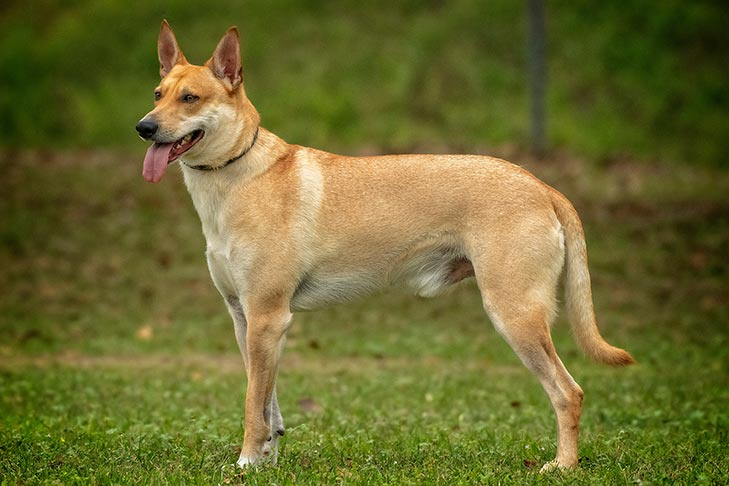

In [45]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [46]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [47]:
import json
response2=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [48]:
type(response2[0][0])

float

In [49]:
response2[0]

[-10.623703002929688,
 -6.631222248077393,
 -4.124002933502197,
 -2.5822179317474365,
 -6.66292142868042,
 -6.0695414543151855,
 -3.9122352600097656,
 -2.7409169673919678,
 -6.748191833496094,
 -2.324080467224121,
 -1.552878975868225,
 -5.28477668762207,
 -1.7724061012268066,
 -0.8081692457199097,
 -6.865199089050293,
 -3.082787036895752,
 -10.816914558410645,
 -4.069808006286621,
 -5.989293575286865,
 -0.5489342212677002,
 -5.498926162719727,
 -2.3356029987335205,
 -8.734627723693848,
 -12.565986633300781,
 -7.004775524139404,
 -10.328789710998535,
 -5.35637903213501,
 -7.961132526397705,
 -5.545843601226807,
 -2.168445110321045,
 -2.735508680343628,
 -6.12349271774292,
 -7.892952919006348,
 -4.580836772918701,
 -8.755044937133789,
 -8.95467472076416,
 -4.772146701812744,
 -4.313000679016113,
 -1.477173089981079,
 -6.4783172607421875,
 -4.998642444610596,
 -2.278229236602783,
 0.383102685213089,
 -6.966065883636475,
 -2.8557627201080322,
 -9.23994255065918,
 -3.4642112255096436,
 -1.9

In [ ]:
import torch
import numpy as np
np.argmax(response, 1)